In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil 
from matplotlib.colors import LinearSegmentedColormap
import datetime
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LassoCV

from sklearn.feature_selection import SelectKBest, SelectPercentile    
from sklearn.feature_selection import chi2, f_classif, f_regression
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

pd.set_option("display.max_columns", None)

In [144]:
random_state = 123
sns.set()
sns.set_context("paper")
sns.set(style="white")

plt.rcParams['figure.dpi'] = 98

colors = ['#646E78','#d1d646', '#97bf78', '#7ca282', '#61858c', '#466796', '#8967b5', '#b363b9', '#d560bc', '#f25dbf']

show_plots = True
save_plots = False
img_counter = 0
kaggle = False
div_colors = ['#466796','#9ca9c3','#f1f1f1','#e5e39f','#d1d646']
div_cmap = LinearSegmentedColormap.from_list("mycmap", div_colors)


def log_transform_data(df, col):
    return np.log1p(df[col])

## Function to plot histograms of numeric features for specified dataframe
def plotHistograms(df, features, rows=4, title = "Histograms of Numeric Variables"):
    if show_plots:
        fig, axes = plt.subplots(rows, ceil(len(features) / rows), \
                             figsize=(11, 3*rows), constrained_layout=True, sharey=True)
        
        for ax, feat in zip(axes.flatten(), features):
            ax.set_title(feat, y=1)
            ax.legend()
            df.pivot(columns='Buy')[feat].plot(kind = 'hist', stacked=True, ax=ax, color=colors[0:2])
    
        if (len(axes.flatten())) > len(features):
            for f in range(len(axes.flatten())-len(features)):
                axes.flatten()[(f+1)*-1].axis('off')
        plt.suptitle(title)
        plt.show()
    else:
        print("show_plots is currently set to False")

## Function to plot histograms of numeric features for specified dataframe
def plot_histograms_boxplots(df, features, rows=4, title = "Histograms of Numeric Variables"):
    if show_plots:
        fig = plt.figure(figsize=(11, 4*rows), constrained_layout=True)
        subfigs = fig.subfigures(rows, ceil(len(features) / rows))
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [4, 1,1]})
        
            df.pivot(columns='IsCanceled')[feat].plot(kind = 'hist', stacked=True, ax=axs[0], color=colors[0:2])
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1)
        
            sns.boxplot(x=df.loc[df['IsCanceled']==0,feat], ax=axs[1], color=colors[0], fliersize=2)
            axs[1].set_xlabel(None)
        
            sns.boxplot(x=df.loc[df['IsCanceled']==1,feat], ax=axs[2], color=colors[1], fliersize=2)
            axs[2].set_xlabel(None)
        
            subf.suptitle(None)

        plt.suptitle(title)
        plt.show()
        if save_plots:
            save_fig(title, fig)
    else:
        print("show_plots is currently set to False")



def make_corr_heatmap(d_X, d_y, method, title="Triangle Correlation Heatmap"):
    if show_plots:
        fig, ax = plt.subplots(figsize=(13, 7))
    
        map_corr = np.round(d_X.join(d_y).corr(method=method),decimals=2)
    
        mask_annot = np.absolute(map_corr.values) >= 0.65
        annot = np.where(mask_annot, map_corr.values, np.full(map_corr.shape,"")) # Try to understand what this np.where() does
        mask = np.triu(np.ones_like(map_corr, dtype=bool))
    
        heatmap = sns.heatmap(map_corr, mask=mask, vmin=-1, vmax=1, annot=annot, cmap=div_cmap, fmt='')
        heatmap.set_title(title, fontdict={'fontsize':18}, pad=16);
        if save_plots:
            save_fig(title, fig)
    else:
        print("show_plots is currently set to False")



def save_fig(title, fig, dest='img/', img_counter=img_counter):
    img_counter = img_counter + 1
    fn = dest + str(img_counter) + '_' + title.replace(' ','-') + '.png'
    fig.savefig(fn, bbox_inches='tight')
    
def plot_cat_counts(df, features, rows=6, title = "Count Distributions of Categorical Variables"):
    if show_plots:
        fig = plt.figure(figsize=(2.85*rows, 4*rows), constrained_layout=True)
        subfigs = fig.subfigures(rows, ceil(len(features) / rows), wspace=0.07, hspace=0.1)
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(1, 2, sharey=True) #, gridspec_kw={'width_ratios': [4, 1,1]})
 
            df1 = df.groupby([feat,'IsCanceled']).size().unstack(1)\
                .plot(kind="barh", stacked=True, ax=axs[0], color=colors)

            df2 = df.groupby([feat,'IsCanceled']).size().unstack(1)
            df2.div(df2.sum(axis=1), axis=0)\
                .plot(kind="barh", stacked=True, ax=axs[1], color=colors)
            
            subf.suptitle(feat)
            

        plt.suptitle(title)
        plt.show()
        if save_plots:
            save_fig(title, fig)

    else:
        print("show_plots is currently set to False")

In [145]:
# data_train_num = data_train.select_dtypes(include=np.number).set_index(data_train.index)
# data_train_cat = data_train.select_dtypes(exclude=np.number).set_index(data_train.index).drop("Buy", axis = 1)
# num_feat = data_train_num.columns.tolist()
# cat_feat = data_train_cat.columns.tolist()

# data_test_num = data_test.select_dtypes(include=np.number).set_index(data_test.index)
# data_test_cat = data_test.select_dtypes(exclude=np.number).set_index(data_test.index)

In [146]:
# original_cat_feats = data_train.select_dtypes(exclude=np.number).columns.tolist()

# plot_cat_counts(data_train, original_cat_feats)

In [147]:
# plot_histograms_boxplots(data_train, num_feat, rows=4)

## IMPORT AND EXPLORATION

In [148]:
data = pd.read_csv("H2.csv")
data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,68.00,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-04-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06
79326,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07
79327,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07
79328,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [149]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   79330 non-null  int64  
 1   LeadTime                     79330 non-null  int64  
 2   ArrivalDateYear              79330 non-null  int64  
 3   ArrivalDateMonth             79330 non-null  object 
 4   ArrivalDateWeekNumber        79330 non-null  int64  
 5   ArrivalDateDayOfMonth        79330 non-null  int64  
 6   StaysInWeekendNights         79330 non-null  int64  
 7   StaysInWeekNights            79330 non-null  int64  
 8   Adults                       79330 non-null  int64  
 9   Children                     79326 non-null  float64
 10  Babies                       79330 non-null  int64  
 11  Meal                         79330 non-null  object 
 12  Country                      79306 non-null  object 
 13  MarketSegment   

In [150]:
# Feature Engineering
data["DurationOfStay"] = data["StaysInWeekNights"] + data["StaysInWeekendNights"]
data["TotalValue"] = data["DurationOfStay"] * data["ADR"]
data["ArrivalDateMonthNumber"] = data["ArrivalDateMonth"].apply(lambda x : datetime.datetime.strptime(x, "%B").month).astype("str")
data["ArrivalDate"] = data["ArrivalDateYear"].astype(str) + "-" + data["ArrivalDateMonthNumber"].astype(str) + "-" + data["ArrivalDateDayOfMonth"].astype(str)
data["ArrivalDate"] = pd.to_datetime(data["ArrivalDate"])
data['ArrivalDayOfWeek'] = data['ArrivalDate'].dt.dayofweek.astype('str')
data.drop("ArrivalDateMonth", inplace = True, axis = 1)
data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek
0,0,6,2015,27,1,0,2,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-03,2,0.00,7,2015-07-01,2
1,1,88,2015,27,1,0,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-07-01,4,306.00,7,2015-07-01,2
2,1,65,2015,27,1,0,4,1,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,68.00,0,1,Canceled,2015-04-30,4,272.00,7,2015-07-01,2
3,1,92,2015,27,1,2,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,2,Canceled,2015-06-23,6,459.00,7,2015-07-01,2
4,1,100,2015,27,2,0,2,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-04-02,2,153.00,7,2015-07-02,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06,7,672.98,8,2017-08-30,2
79326,0,102,2017,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07,7,1578.01,8,2017-08-31,3
79327,0,34,2017,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07,7,1103.97,8,2017-08-31,3
79328,0,109,2017,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07,7,730.80,8,2017-08-31,3


In [151]:
# Feature Engineering
data["ReservationStatusDate"] = pd.to_datetime(data["ReservationStatusDate"])

data['ReservationDayOfMonth'] = data['ReservationStatusDate'].dt.day.astype('str')
data['ReservationWeekOfYear'] = data['ReservationStatusDate'].dt.weekofyear.astype('str')
data['ReservationMonth'] = data['ReservationStatusDate'].dt.month.astype('str')
data['ReservationDayOfWeek'] = data['ReservationStatusDate'].dt.dayofweek.astype('str')

data["IsRoomChanged"] = (data["AssignedRoomType"] != data["ReservedRoomType"]).astype("int")

In [152]:
data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
0,0,6,2015,27,1,0,2,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-03,2,0.00,7,2015-07-01,2,3,27,7,4,0
1,1,88,2015,27,1,0,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-07-01,4,306.00,7,2015-07-01,2,1,27,7,2,0
2,1,65,2015,27,1,0,4,1,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,68.00,0,1,Canceled,2015-04-30,4,272.00,7,2015-07-01,2,30,18,4,3,0
3,1,92,2015,27,1,2,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,2,Canceled,2015-06-23,6,459.00,7,2015-07-01,2,23,26,6,1,0
4,1,100,2015,27,2,0,2,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-04-02,2,153.00,7,2015-07-02,3,2,14,4,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06,7,672.98,8,2017-08-30,2,6,36,9,2,0
79326,0,102,2017,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07,7,1578.01,8,2017-08-31,3,7,36,9,3,0
79327,0,34,2017,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07,7,1103.97,8,2017-08-31,3,7,36,9,3,0
79328,0,109,2017,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07,7,730.80,8,2017-08-31,3,7,36,9,3,0


In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   IsCanceled                   79330 non-null  int64         
 1   LeadTime                     79330 non-null  int64         
 2   ArrivalDateYear              79330 non-null  int64         
 3   ArrivalDateWeekNumber        79330 non-null  int64         
 4   ArrivalDateDayOfMonth        79330 non-null  int64         
 5   StaysInWeekendNights         79330 non-null  int64         
 6   StaysInWeekNights            79330 non-null  int64         
 7   Adults                       79330 non-null  int64         
 8   Children                     79326 non-null  float64       
 9   Babies                       79330 non-null  int64         
 10  Meal                         79330 non-null  object        
 11  Country                      79306 non-nu

In [154]:
# saving numeric features into a list
numeric_features = data.select_dtypes(include=np.number).set_index(data.index).columns.tolist()
data[numeric_features]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,DurationOfStay,TotalValue,IsRoomChanged
0,0,6,2015,27,1,0,2,1,0.0,0,0,0,0,0,0,0.00,0,0,2,0.00,0
1,1,88,2015,27,1,0,4,2,0.0,0,0,0,0,0,0,76.50,0,1,4,306.00,0
2,1,65,2015,27,1,0,4,1,0.0,0,0,0,0,0,0,68.00,0,1,4,272.00,0
3,1,92,2015,27,1,2,4,2,0.0,0,0,0,0,0,0,76.50,0,2,6,459.00,0
4,1,100,2015,27,2,0,2,2,0.0,0,0,0,0,0,0,76.50,0,1,2,153.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,35,30,2,5,2,0.0,0,0,0,0,0,0,96.14,0,0,7,672.98,0
79326,0,102,2017,35,31,2,5,3,0.0,0,0,0,0,0,0,225.43,0,2,7,1578.01,0
79327,0,34,2017,35,31,2,5,2,0.0,0,0,0,0,0,0,157.71,0,4,7,1103.97,0
79328,0,109,2017,35,31,2,5,2,0.0,0,0,0,0,0,0,104.40,0,0,7,730.80,0


In [155]:
# metric_features is a subset of numeric_features

to_discard = ["ArrivalDateYear", "ArrivalDateDayOfMonth", "IsRepeatedGuest", "IsCanceled", "IsRoomChanged"]

metric_features = numeric_features.copy()
for feat in to_discard:
    metric_features.remove(feat)

In [156]:
categorical_features = data.select_dtypes(exclude=np.number).set_index(data.index).columns.tolist()

#adding the numeric non metric features
categorical_features.extend(to_discard)

data[categorical_features]

,Meal,Country,MarketSegment,DistributionChannel,ReservedRoomType,AssignedRoomType,DepositType,Agent,Company,CustomerType,ReservationStatus,ReservationStatusDate,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,ArrivalDateYear,ArrivalDateDayOfMonth,IsRepeatedGuest,IsCanceled,IsRoomChanged
0,HB,PRT,Offline TA/TO,TA/TO,A,A,No Deposit,6,NULL,Transient,Check-Out,2015-07-03,7,2015-07-01,2,3,27,7,4,2015,1,0,0,0
1,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9,NULL,Transient,Canceled,2015-07-01,7,2015-07-01,2,1,27,7,2,2015,1,0,1,0
2,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9,NULL,Transient,Canceled,2015-04-30,7,2015-07-01,2,30,18,4,3,2015,1,0,1,0
3,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9,NULL,Transient,Canceled,2015-06-23,7,2015-07-01,2,23,26,6,1,2015,1,0,1,0
4,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9,NULL,Transient,Canceled,2015-04-02,7,2015-07-02,3,2,14,4,3,2015,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,BB,BEL,Offline TA/TO,TA/TO,A,A,No Deposit,394,NULL,Transient,Check-Out,2017-09-06,8,2017-08-30,2,6,36,9,2,2017,30,0,0,0
79326,BB,FRA,Online TA,TA/TO,E,E,No Deposit,9,NULL,Transient,Check-Out,2017-09-07,8,2017-08-31,3,7,36,9,3,2017,31,0,0,0
79327,BB,DEU,Online TA,TA/TO,D,D,No Deposit,9,NULL,Transient,Check-Out,2017-09-07,8,2017-08-31,3,7,36,9,3,2017,31,0,0,0
79328,BB,GBR,Online TA,TA/TO,A,A,No Deposit,89,NULL,Transient,Check-Out,2017-09-07,8,2017-08-31,3,7,36,9,3,2017,31,0,0,0


In [157]:
data.describe(include="all").T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
IsCanceled,79330.0,NaN,NaN,NaN,NaT,NaT,0.41727,0.493111,0.0,0.0,0.0,1.0,1.0
LeadTime,79330.0,NaN,NaN,NaN,NaT,NaT,109.735724,110.948526,0.0,23.0,74.0,163.0,629.0
ArrivalDateYear,79330.0,NaN,NaN,NaN,NaT,NaT,2016.174285,0.699181,2015.0,2016.0,2016.0,2017.0,2017.0
ArrivalDateWeekNumber,79330.0,NaN,NaN,NaN,NaT,NaT,27.177449,13.398523,1.0,17.0,27.0,38.0,53.0
ArrivalDateDayOfMonth,79330.0,NaN,NaN,NaN,NaT,NaT,15.786625,8.728451,1.0,8.0,16.0,23.0,31.0
StaysInWeekendNights,79330.0,NaN,NaN,NaN,NaT,NaT,0.795185,0.885026,0.0,0.0,1.0,2.0,16.0
StaysInWeekNights,79330.0,NaN,NaN,NaN,NaT,NaT,2.182957,1.456416,0.0,1.0,2.0,3.0,41.0
Adults,79330.0,NaN,NaN,NaN,NaT,NaT,1.850977,0.509292,0.0,2.0,2.0,2.0,4.0
Children,79326.0,NaN,NaN,NaN,NaT,NaT,0.09137,0.372177,0.0,0.0,0.0,0.0,3.0
Babies,79330.0,NaN,NaN,NaN,NaT,NaT,0.004941,0.084323,0.0,0.0,0.0,0.0,10.0


### Duplicates

In [308]:
data_test = data.copy()
print("Percentage of suspect duplicated data: " , (data_test.duplicated().sum() / len(data)) * 100)

Percentage of suspect duplicated data:  32.65095172066053


In [312]:
data_test[data_test["MarketSegment"] == "Groups"].groupby(data_test.columns.tolist(),as_index=False).size().sort_values("size", ascending = False)
# data_test[data_test["CustomerType"] == "Group"].groupby(data_test.columns.tolist(),as_index=False).size().sort_values("size", ascending = False)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged,size
0,0,0,2015,31,31,2,2,2,0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1,NULL,0,Transient,36.0,0,0,Check-Out,2015-08-04,4,144.0,7,2015-07-31,4,4,32,8,1,0,1
1750,1,1,2015,37,6,2,0,0,0,0,SC,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1,NULL,0,Transient-Party,0.0,0,0,Canceled,2015-09-05,2,0.0,9,2015-09-06,6,5,36,9,5,0,1
1752,1,1,2015,37,6,2,0,1,0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1,NULL,0,Transient-Party,75.0,0,0,Canceled,2015-09-05,2,150.0,9,2015-09-06,6,5,36,9,5,0,1
1753,1,1,2015,44,28,0,3,2,0,0,HB,PRT,Groups,TA/TO,1,1,0,A,A,0,No Deposit,37,NULL,0,Transient-Party,111.0,0,0,Canceled,2015-10-27,3,333.0,10,2015-10-28,2,27,44,10,1,0,1
1754,1,1,2015,53,29,0,4,2,0,1,BB,PRT,Groups,TA/TO,0,0,0,B,B,2,No Deposit,29,NULL,0,Transient,72.5,0,2,Canceled,2015-12-29,4,290.0,12,2015-12-29,1,29,53,12,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,0,61,2015,36,5,2,2,3,0,0,BB,ESP,Groups,TA/TO,0,0,0,A,D,1,No Deposit,1,NULL,0,Transient-Party,84.0,0,1,Check-Out,2015-09-09,4,336.0,9,2015-09-05,5,9,37,9,2,1,1
880,0,61,2015,48,23,1,2,1,0,0,BB,EGY,Groups,TA/TO,0,0,0,A,A,0,No Deposit,37,NULL,0,Transient-Party,70.0,0,0,Check-Out,2015-11-26,3,210.0,11,2015-11-23,0,26,48,11,3,0,1
881,0,61,2015,48,23,1,2,1,0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,37,NULL,0,Transient-Party,70.0,0,0,Check-Out,2015-11-26,3,210.0,11,2015-11-23,0,26,48,11,3,0,1
882,0,61,2015,48,23,1,3,1,0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,37,NULL,0,Transient-Party,70.0,0,0,Check-Out,2015-11-27,4,280.0,11,2015-11-23,0,27,48,11,4,0,1


In [310]:
#Removing duplicated records accountable to groups

# Removes all records (except one) for duplicated values with Market Segment = Groups
data_test = data_test[~(data_test.duplicated(keep="first") & data_test['MarketSegment'].eq('Groups'))]

# Removes all records (except one) for duplicated values with CustomerType = Group
# data_test = data_test[~(data_test.duplicated(keep="first") & data_test['CustomerType'].eq('Group'))]

In [ ]:
# Check greater size = 1
data_test[data_test["MarketSegment"] == "Groups"].groupby(data_test.columns.tolist(),as_index=False).size().sort_values("size", ascending = False)
# data_test[data_test["CustomerType"] == "Group"].groupby(data_test.columns.tolist(),as_index=False).size().sort_values("size", ascending = False)

In [311]:
print("Percentage of kept records after removal: " , (len(data_test) / len(data)) * 100)

Percentage of kept records after removal:  85.70528173452666


In [245]:
len(data_test)

53157

In [159]:
#TODO remove duplicates having Group as Market Segment to avoid overfitting for those records

In [160]:
# Let's analyze the duplicates
duplicates = data.loc[data.duplicated()]
duplicates = duplicates.groupby(duplicates.columns.tolist(),as_index=False).size().sort_values("size", ascending = False)
size = duplicates.pop("size")
duplicates.insert(0, "size", size)
duplicates

,size,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
5405,179,1,277,2016,46,7,1,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,NULL,NULL,0,Transient,100.00,0,0,Canceled,2016-04-04,3,300.00,11,2016-11-07,0,4,14,4,0,0
4180,149,1,68,2016,8,17,0,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,37,NULL,0,Transient,75.00,0,0,Canceled,2016-01-06,2,150.00,2,2016-02-17,2,6,1,1,2,0
5073,108,1,188,2016,25,15,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,119,NULL,39,Transient,130.00,0,0,Canceled,2016-01-18,2,260.00,6,2016-06-15,2,18,3,1,0,0
4878,100,1,158,2016,22,24,0,2,1,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,37,NULL,31,Transient,130.00,0,0,Canceled,2016-01-18,2,260.00,5,2016-05-24,1,18,3,1,0,0
3851,99,1,34,2015,50,8,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,1,0,A,A,0,Non Refund,19,NULL,0,Transient,90.00,0,0,Canceled,2015-11-17,2,180.00,12,2015-12-08,1,17,47,11,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,1,0,59,2017,17,26,0,1,2,0.0,0,BB,CHE,Direct,Direct,0,0,0,D,D,0,No Deposit,14,NULL,0,Transient,130.50,0,2,Check-Out,2017-04-27,1,130.50,4,2017-04-26,2,27,17,4,3,0
1480,1,0,59,2017,14,6,0,3,2,0.0,0,BB,ISR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,117.00,0,2,Check-Out,2017-04-09,3,351.00,4,2017-04-06,3,9,14,4,6,0
1479,1,0,59,2017,12,23,0,1,2,0.0,0,SC,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,79.20,0,0,Check-Out,2017-03-24,1,79.20,3,2017-03-23,3,24,12,3,4,0
3383,1,0,409,2017,22,31,0,3,2,0.0,0,BB,AUS,Groups,TA/TO,0,0,0,A,A,0,No Deposit,229,NULL,0,Transient-Party,112.67,0,2,Check-Out,2017-06-03,3,338.01,5,2017-05-31,2,3,22,6,5,0


In [161]:
#Exploring the day with most populated duplicates
data.loc[(data.ArrivalDateDayOfMonth == 7) & 
(data.ArrivalDateMonthNumber == 11) & 
(data.ArrivalDateYear == 2016)
]["MarketSegment"].value_counts()

Series([], Name: MarketSegment, dtype: int64)

In [162]:
data.loc[(data.ArrivalDateDayOfMonth == 7) & 
(data.ArrivalDateMonthNumber == 11) & 
(data.ArrivalDateYear == 2016) & 
(data.MarketSegment == "Groups")
]["Agent"].value_counts()

Series([], Name: Agent, dtype: int64)

In [163]:
data.loc[(data.ArrivalDateDayOfMonth == 7) & 
(data.ArrivalDateMonthNumber == 11) & 
(data.ArrivalDateYear == 2016)
].value_counts("MarketSegment")

Series([], dtype: int64)

In [164]:
data.loc[data.duplicated()].sort_values("ArrivalDateDayOfMonth")

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
23073,1,56,2017,5,1,0,3,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,29,NULL,0,Transient,60.00,0,0,Canceled,2016-12-07,3,180.0,2,2017-02-01,2,7,49,12,2,0
23105,1,56,2017,5,1,0,3,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,29,NULL,0,Transient,60.00,0,0,Canceled,2016-12-07,3,180.0,2,2017-02-01,2,7,49,12,2,0
23104,1,56,2017,5,1,0,3,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,29,NULL,0,Transient,60.00,0,0,Canceled,2016-12-07,3,180.0,2,2017-02-01,2,7,49,12,2,0
23103,1,56,2017,5,1,0,3,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,29,NULL,0,Transient,60.00,0,0,Canceled,2016-12-07,3,180.0,2,2017-02-01,2,7,49,12,2,0
23102,1,56,2017,5,1,0,3,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,29,NULL,0,Transient,60.00,0,0,Canceled,2016-12-07,3,180.0,2,2017-02-01,2,7,49,12,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36391,1,379,2015,44,31,1,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,1,NULL,0,Transient,62.00,0,0,Canceled,2015-07-23,2,124.0,10,2015-10-31,5,23,30,7,3,0
36390,1,379,2015,44,31,1,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,1,NULL,0,Transient,62.00,0,0,Canceled,2015-07-23,2,124.0,10,2015-10-31,5,23,30,7,3,0
36389,1,379,2015,44,31,1,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,1,NULL,0,Transient,62.00,0,0,Canceled,2015-07-23,2,124.0,10,2015-10-31,5,23,30,7,3,0
36387,1,379,2015,44,31,1,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,1,NULL,0,Transient,62.00,0,0,Canceled,2015-07-23,2,124.0,10,2015-10-31,5,23,30,7,3,0


### Missing values

In [165]:
# Checking NaN values
data.isna().sum(axis = 0).loc[data.isna().sum(axis = 0) > 0]

Children     4
Country     24
dtype: int64

In [166]:
#Cardinalities of children values
data["Children"].value_counts()

0.0    74220
1.0     3023
2.0     2024
3.0       59
Name: Children, dtype: int64

In [167]:
# Cardinalities for countries
data["Country"].value_counts()

PRT    30960
FRA     8804
DEU     6084
GBR     5315
ESP     4611
       ...  
MMR        1
UMI        1
NIC        1
VGB        1
COM        1
Name: Country, Length: 166, dtype: int64

In [168]:
# Replacing NaN values with the mode 

data["Children"].replace(np.nan, data["Children"].mode()[0], inplace = True) #MODE = 0
data["Country"].replace(np.nan, data["Country"].mode()[0], inplace = True)   #MODE = PRT

data.loc[(data["Children"].isna() == True) | (data["Country"].isna() == True)]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged


In [169]:
data["Children"] = data["Children"].astype("int")

### Data exploration

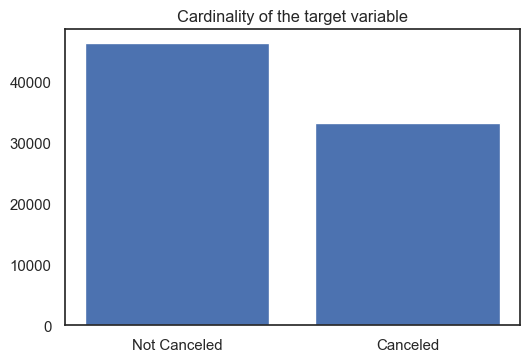

In [170]:
sns.set(style = "white")
plt.bar(height=data["IsCanceled"].value_counts(), x = ["Not Canceled", "Canceled"])
plt.title("Cardinality of the target variable")
plt.show()

In [171]:
def pairwise_relation(data, features = data.select_dtypes(include=np.number).set_index(data.index).columns,
 title = "Pairwise Relationship of Metric Variables", target = "IsCanceled"):
    
    # Pairwise Relationship of Numerical Variables
    sns.set(style='white')

    # Setting pairplot
    sns.pairplot(data[features], diag_kind="hist", hue=target)

    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle(title)

    plt.show()

In [172]:
#around 35 minutes or run time

# pairwise_relationship(data)

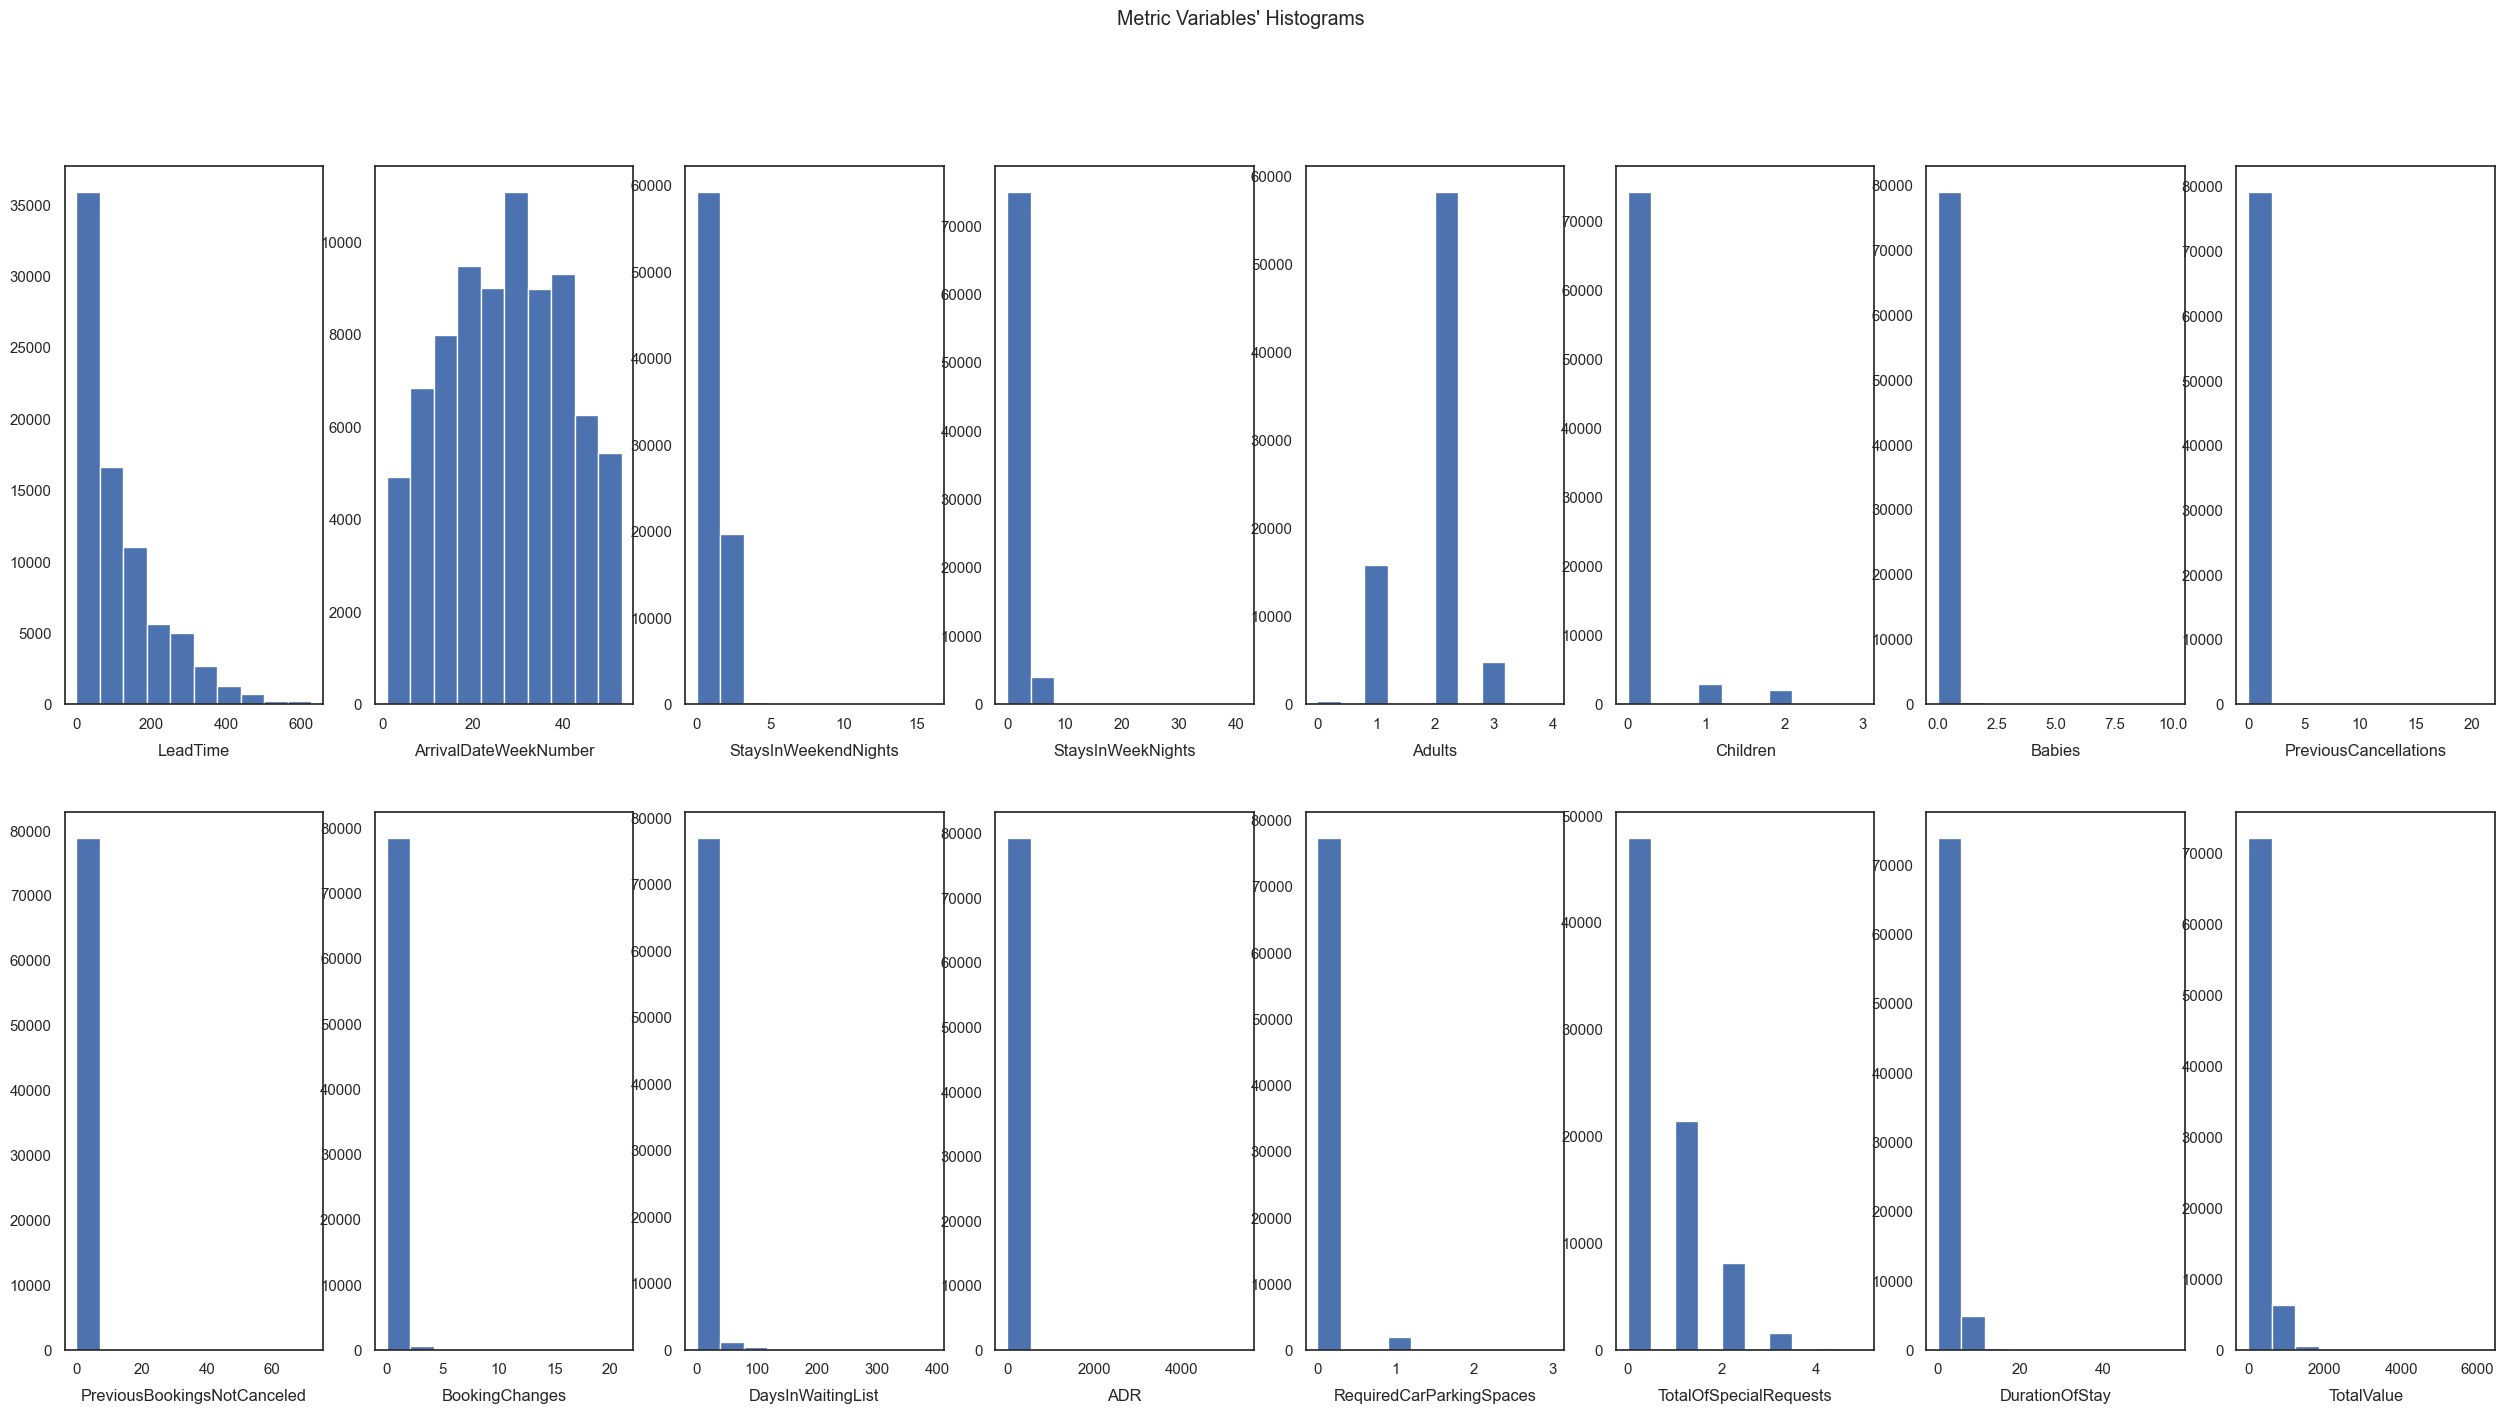

In [173]:
sns.set(style='white')

fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(32, 16))

for ax, feat in zip(axes.flatten(), metric_features):
    ax.hist(data[feat])
    ax.set_title(feat, y=-0.11)
    
title = "Metric Variables' Histograms"
plt.suptitle(title)
plt.show()

In [174]:
# Checking for consistency in high values for StaysInWeekNights
data.sort_values("StaysInWeekNights", ascending=False)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
61734,0,140,2016,39,22,16,41,0,0,0,SC,GBR,Online TA,TA/TO,0,0,0,A,K,12,No Deposit,9,NULL,0,Transient,8.34,0,2,Check-Out,2016-11-18,57,475.38,9,2016-09-22,3,18,46,11,4,1
47957,0,16,2016,11,11,14,35,0,0,0,BB,PRT,Corporate,TA/TO,0,0,0,A,K,21,No Deposit,NULL,215,0,Transient-Party,0.00,0,0,Check-Out,2016-04-29,49,0.00,3,2016-03-11,4,29,17,4,4,1
14644,0,206,2016,30,23,14,34,2,0,0,SC,PRT,Online TA,TA/TO,0,0,0,A,K,6,No Deposit,9,NULL,0,Transient-Party,0.00,0,1,Check-Out,2016-09-09,48,0.00,7,2016-07-23,5,9,36,9,4,1
66501,0,11,2017,3,15,13,30,0,0,0,SC,USA,Online TA,TA/TO,0,0,0,A,K,14,No Deposit,9,NULL,0,Transient,0.00,0,0,Check-Out,2017-02-27,43,0.00,1,2017-01-15,6,27,9,2,0,1
63222,0,3,2016,47,14,9,25,2,0,0,BB,PRT,Corporate,Corporate,0,0,0,A,A,3,No Deposit,NULL,368,0,Transient,93.00,0,0,Check-Out,2016-12-18,34,3162.00,11,2016-11-14,0,18,50,12,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61073,0,42,2016,46,7,0,0,1,0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,2,No Deposit,10,NULL,0,Transient,0.00,0,0,Check-Out,2016-11-07,0,0.00,11,2016-11-07,0,7,45,11,0,0
74237,0,20,2017,25,19,1,0,1,0,0,BB,DZA,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,85,NULL,0,Transient,94.00,0,0,Check-Out,2017-06-20,1,94.00,6,2017-06-19,0,20,25,6,1,0
74236,0,21,2017,25,19,1,0,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,150.00,0,1,Check-Out,2017-06-20,1,150.00,6,2017-06-19,0,20,25,6,1,0
74234,0,3,2017,25,19,1,0,2,0,0,BB,DEU,Direct,Direct,0,0,0,A,D,1,No Deposit,NULL,NULL,0,Transient,160.00,0,0,Check-Out,2017-06-20,1,160.00,6,2017-06-19,0,20,25,6,1,1


In [175]:
def boxplot (data, features = data.select_dtypes(include=np.number).set_index(data.index).columns):
    
    
    sns.set(style = 'white')
    fig, axes = plt.subplots(2, ceil(len(features) / 2), figsize=(20, 16))
    
    for ax, feat in zip(axes.flatten(), features): 

        sns.boxplot(data[feat], ax = ax)
        
    title = "Metric Variables' Boxplots"

    plt.suptitle(title)

    plt.show()

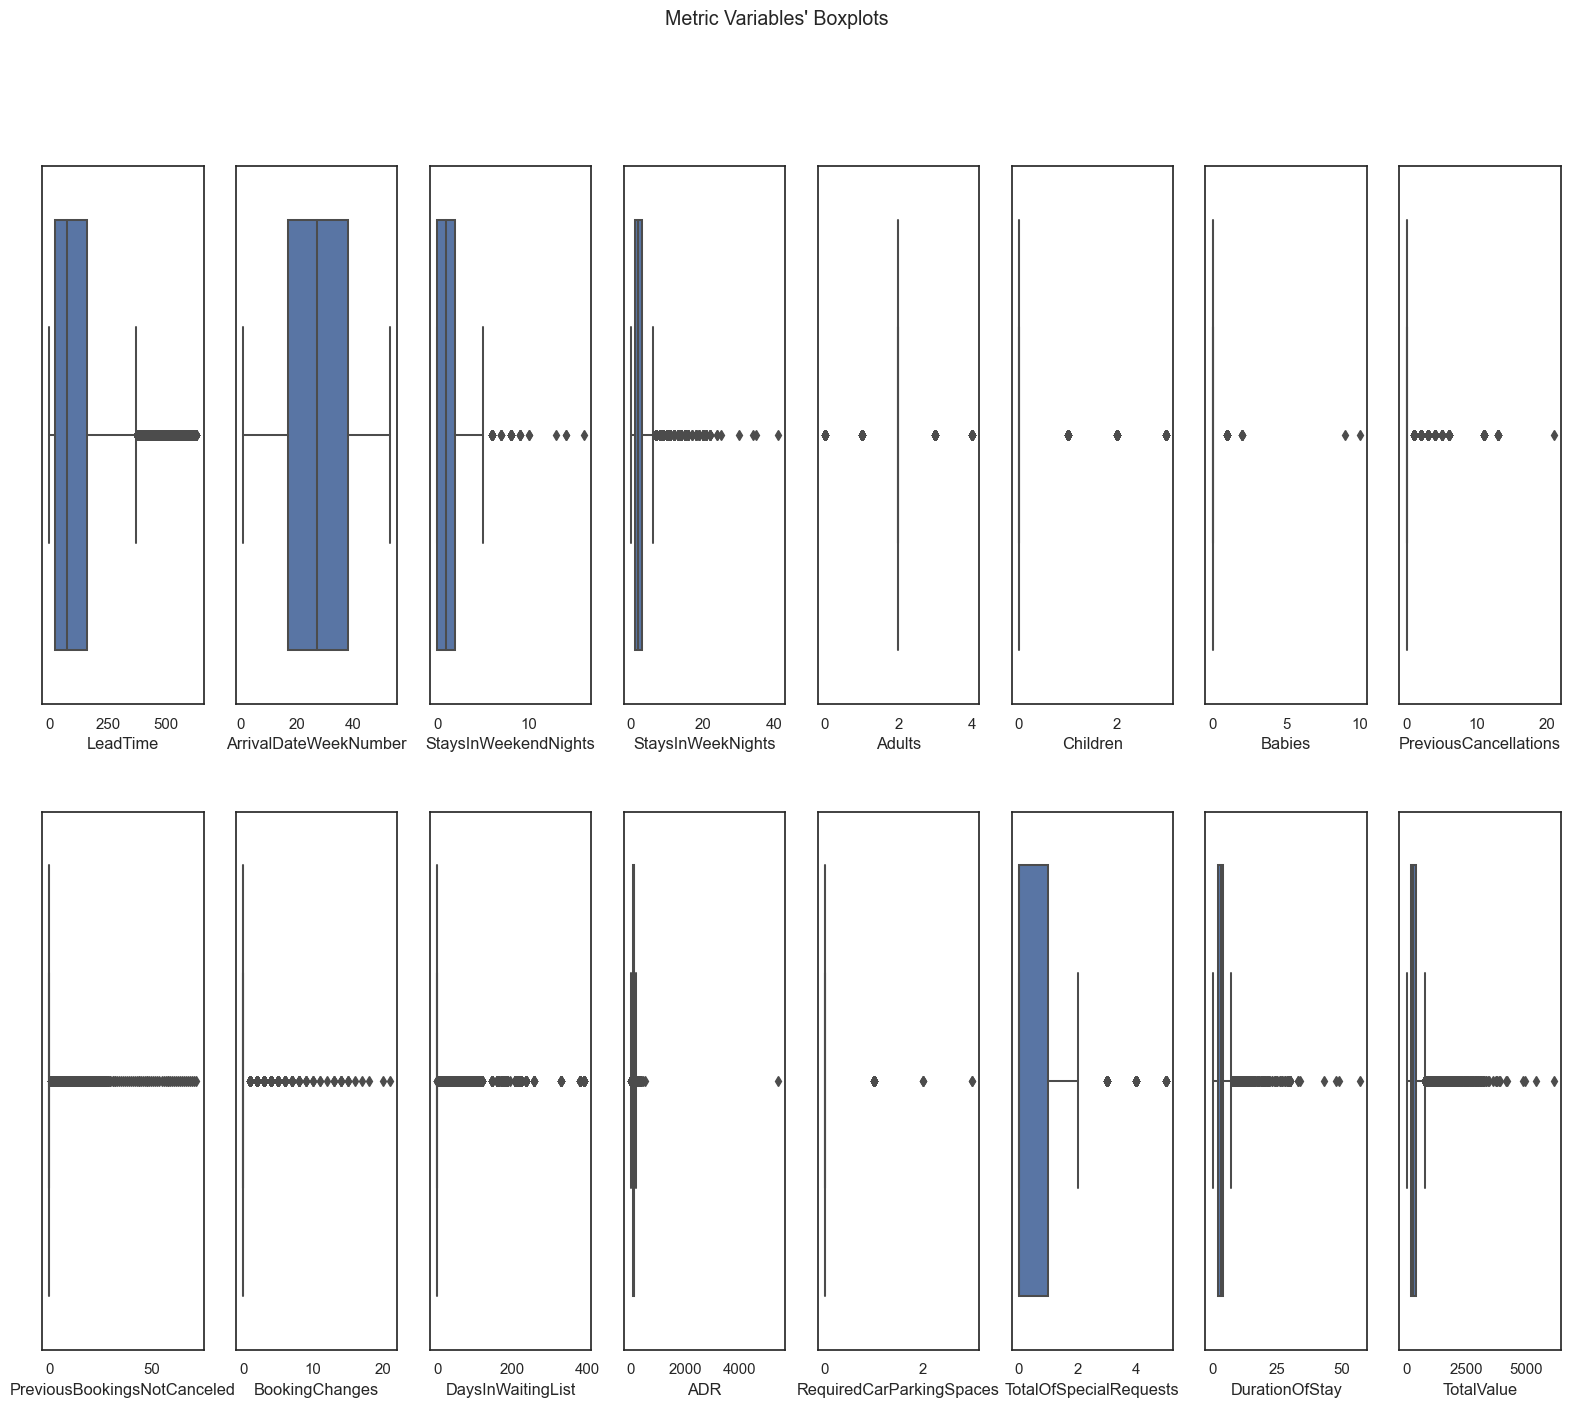

In [176]:
boxplot(data, metric_features)

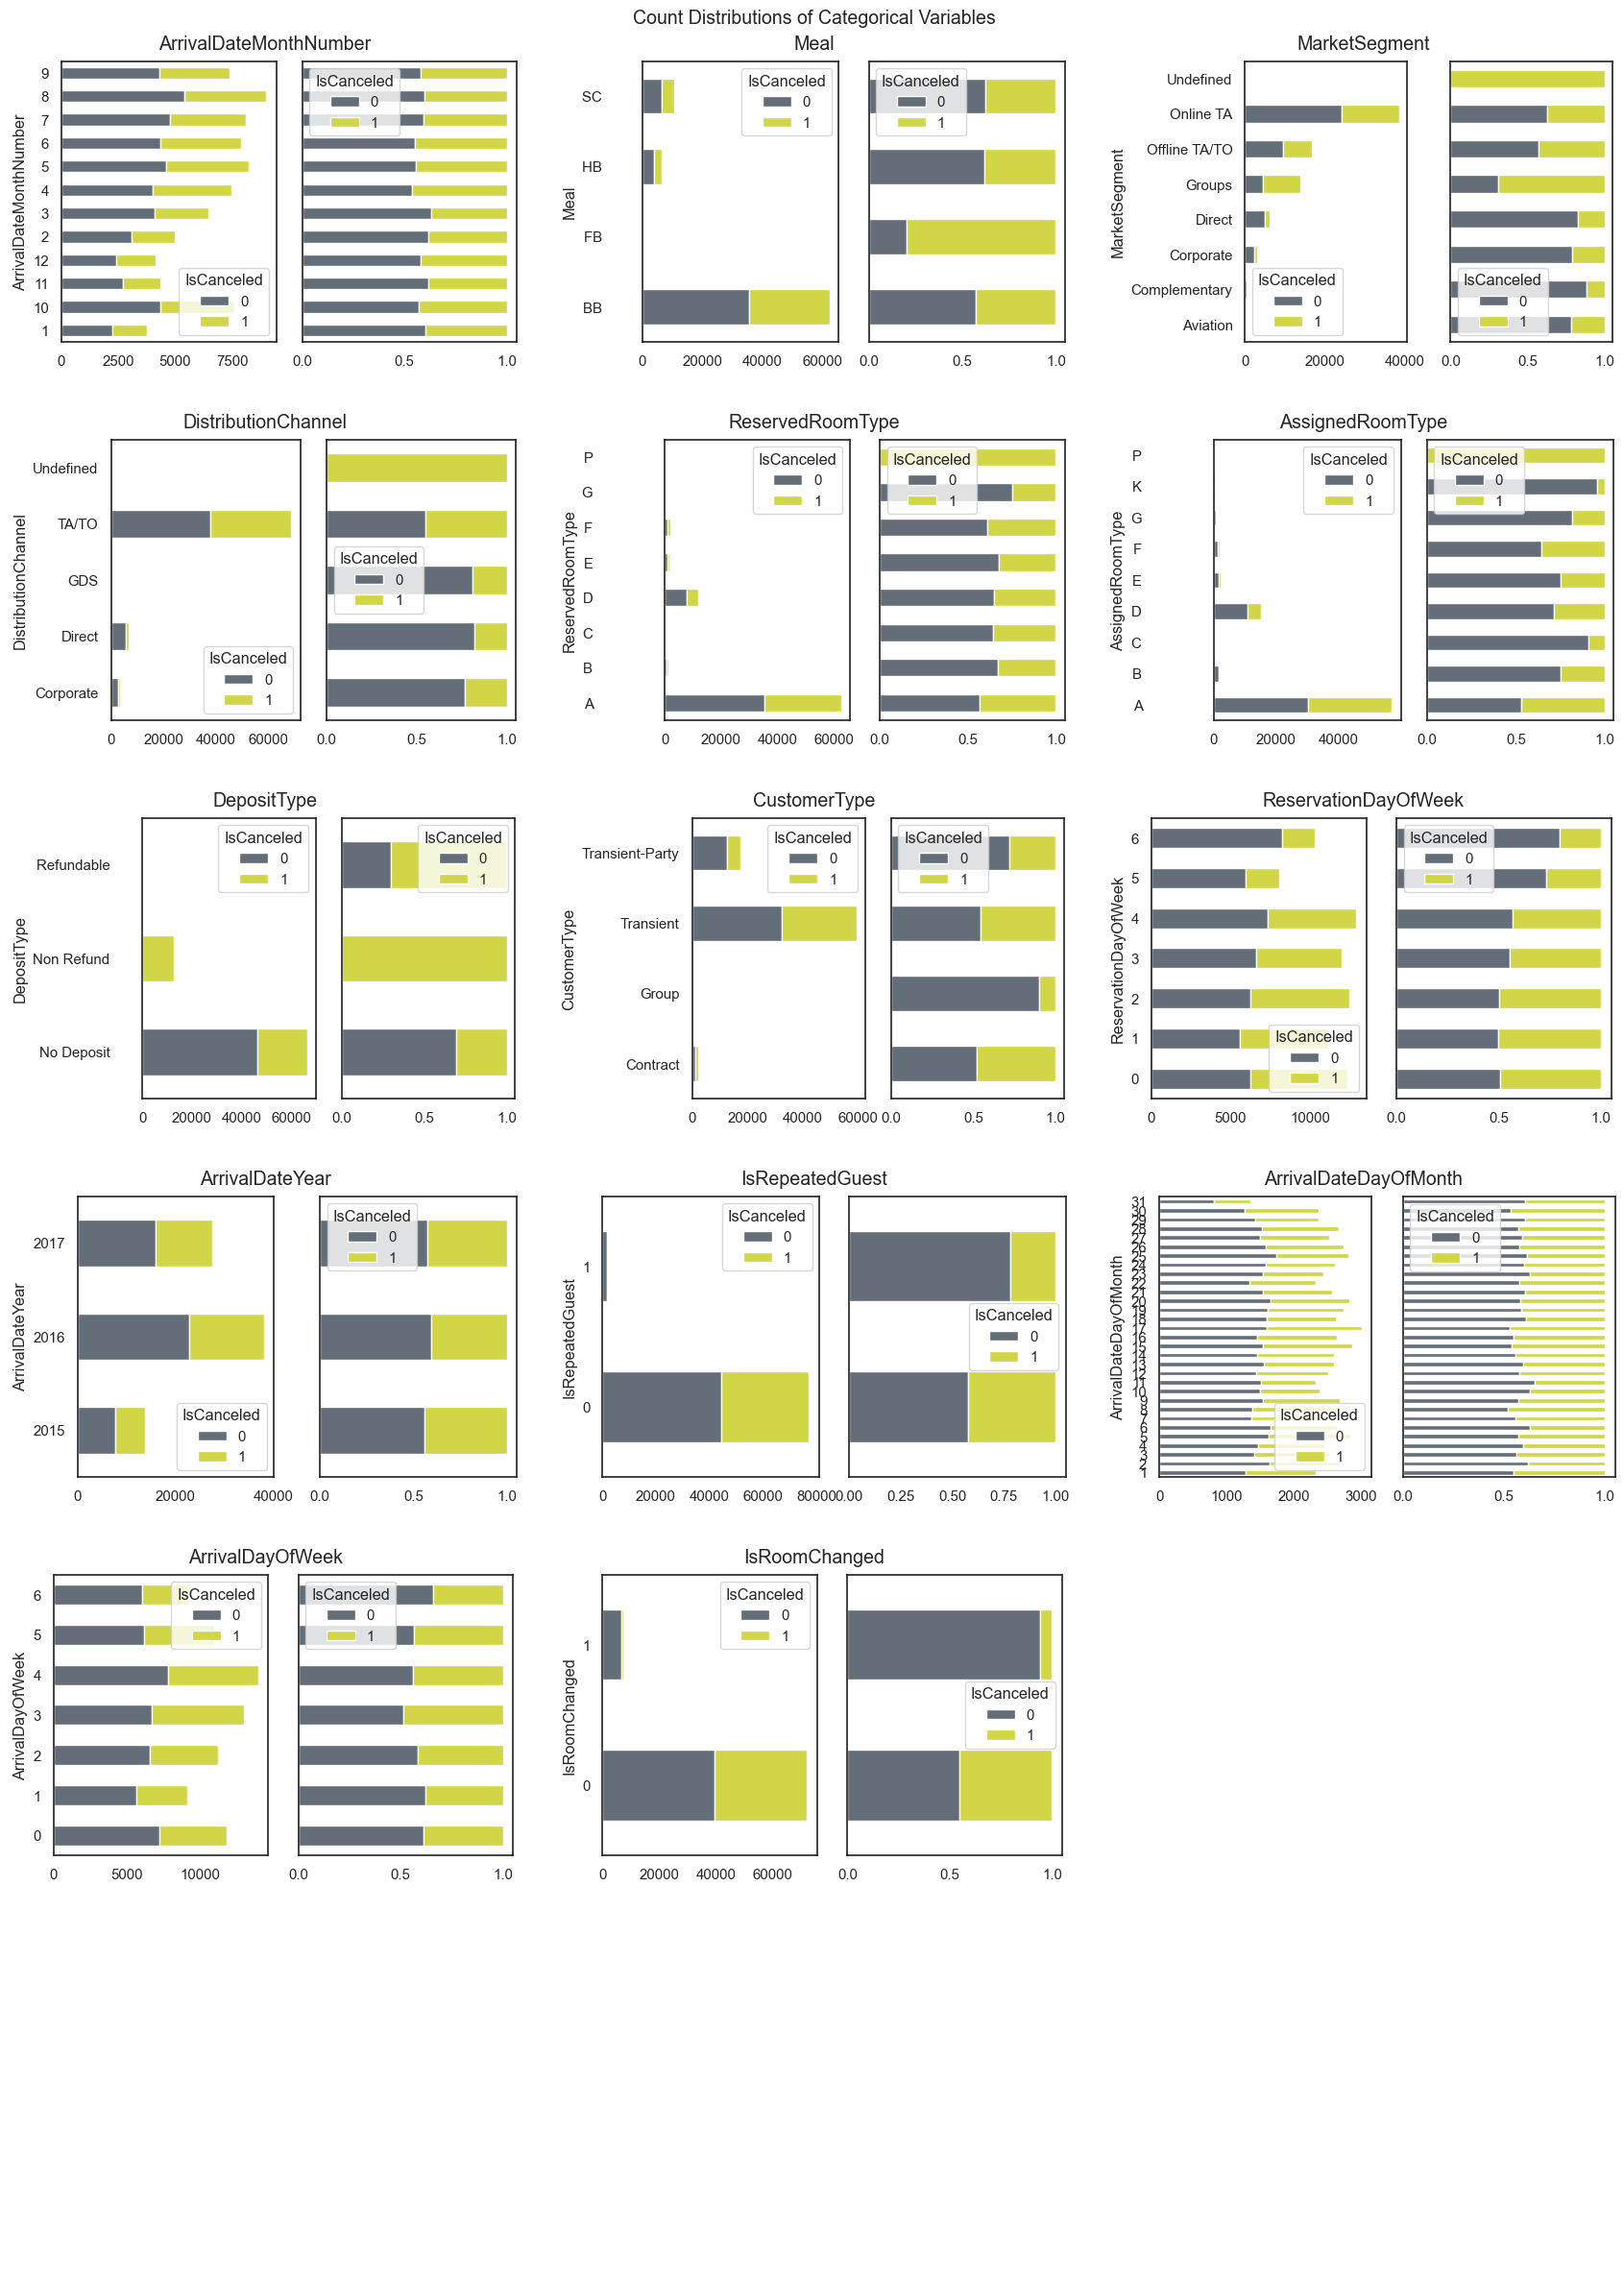

In [177]:
to_plot = ['ArrivalDateMonthNumber', 'Meal','MarketSegment','DistributionChannel', 'ReservedRoomType', 'AssignedRoomType',
'DepositType', 'CustomerType', 'ReservationDayOfWeek', 'ArrivalDateYear', 'IsRepeatedGuest', 'ArrivalDateDayOfMonth', "ArrivalDayOfWeek",
"IsRoomChanged"]

plot_cat_counts(data, to_plot)

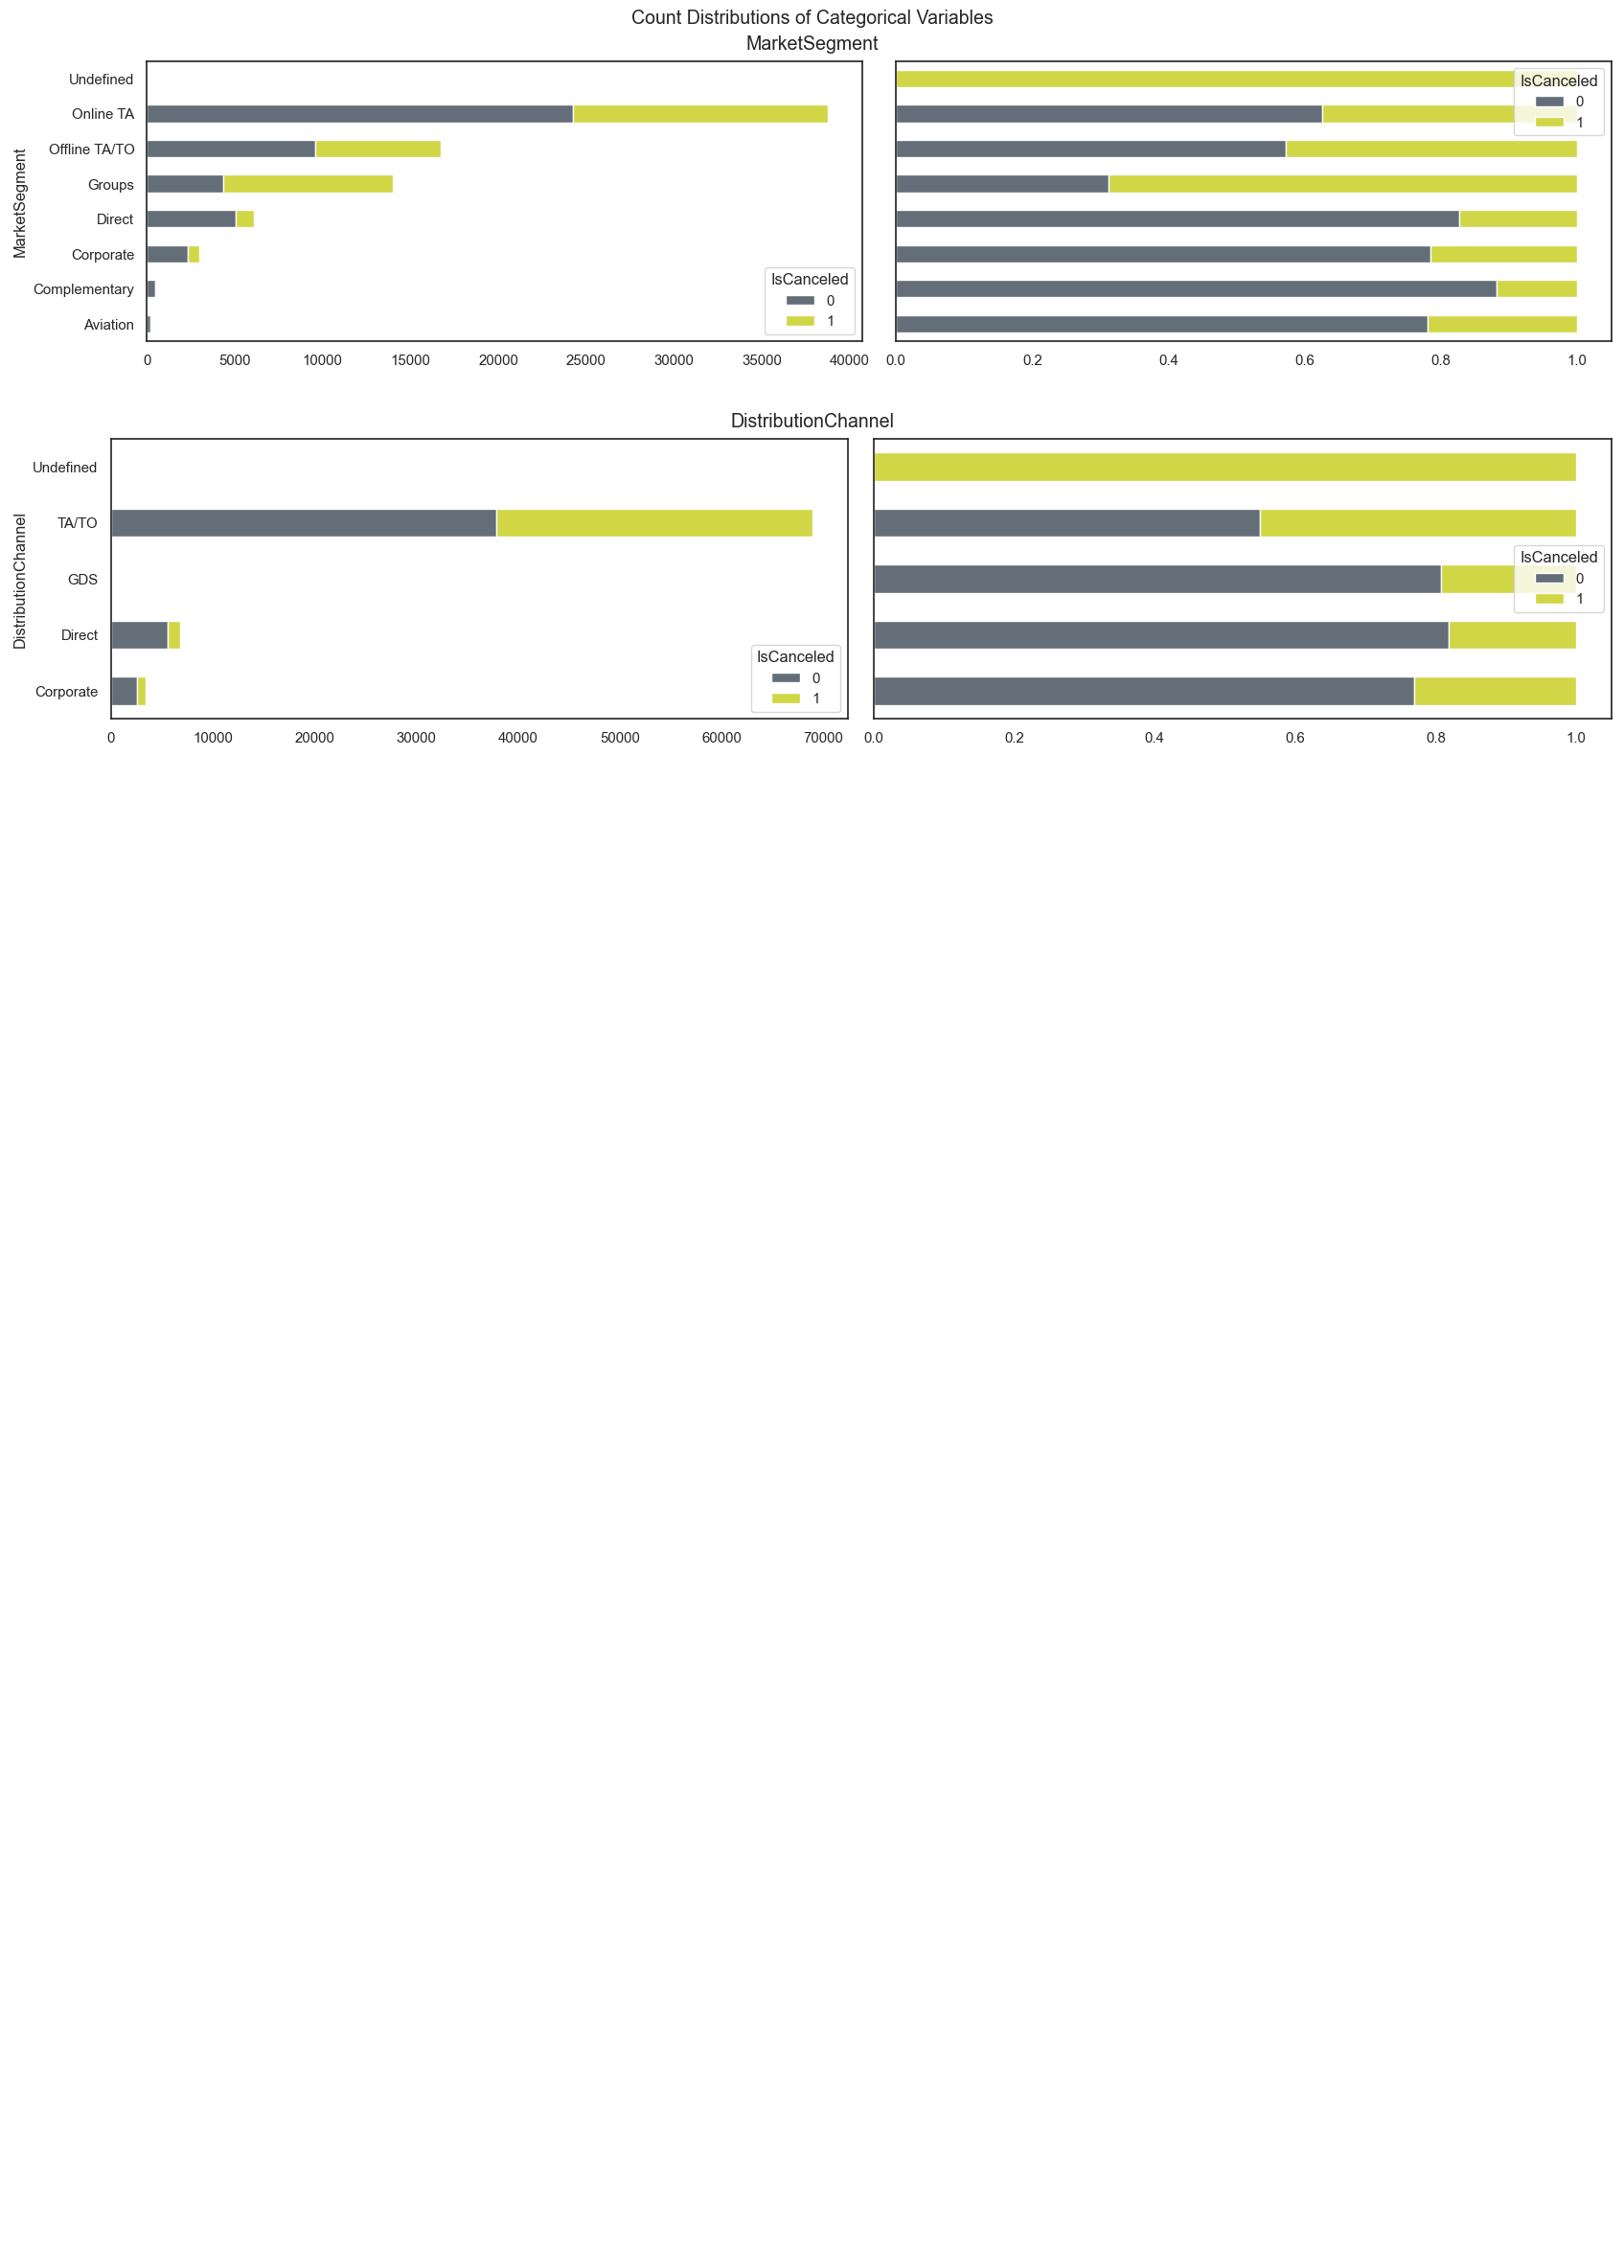

In [118]:
to_plot = ['MarketSegment','DistributionChannel']

plot_cat_counts(data, to_plot)

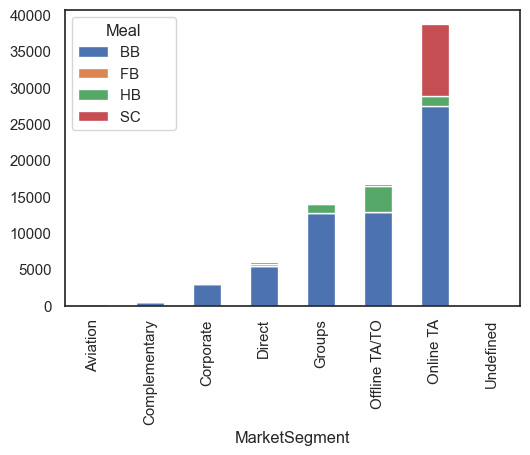

In [127]:
# Let's break this down, step by step (pandas plot - matplotlib behind)
sns.set(style='white')
data_counts = data\
    .groupby(['MarketSegment', 'Meal'])\
    .size()\
    .unstack()\
    .plot.bar(stacked=True)

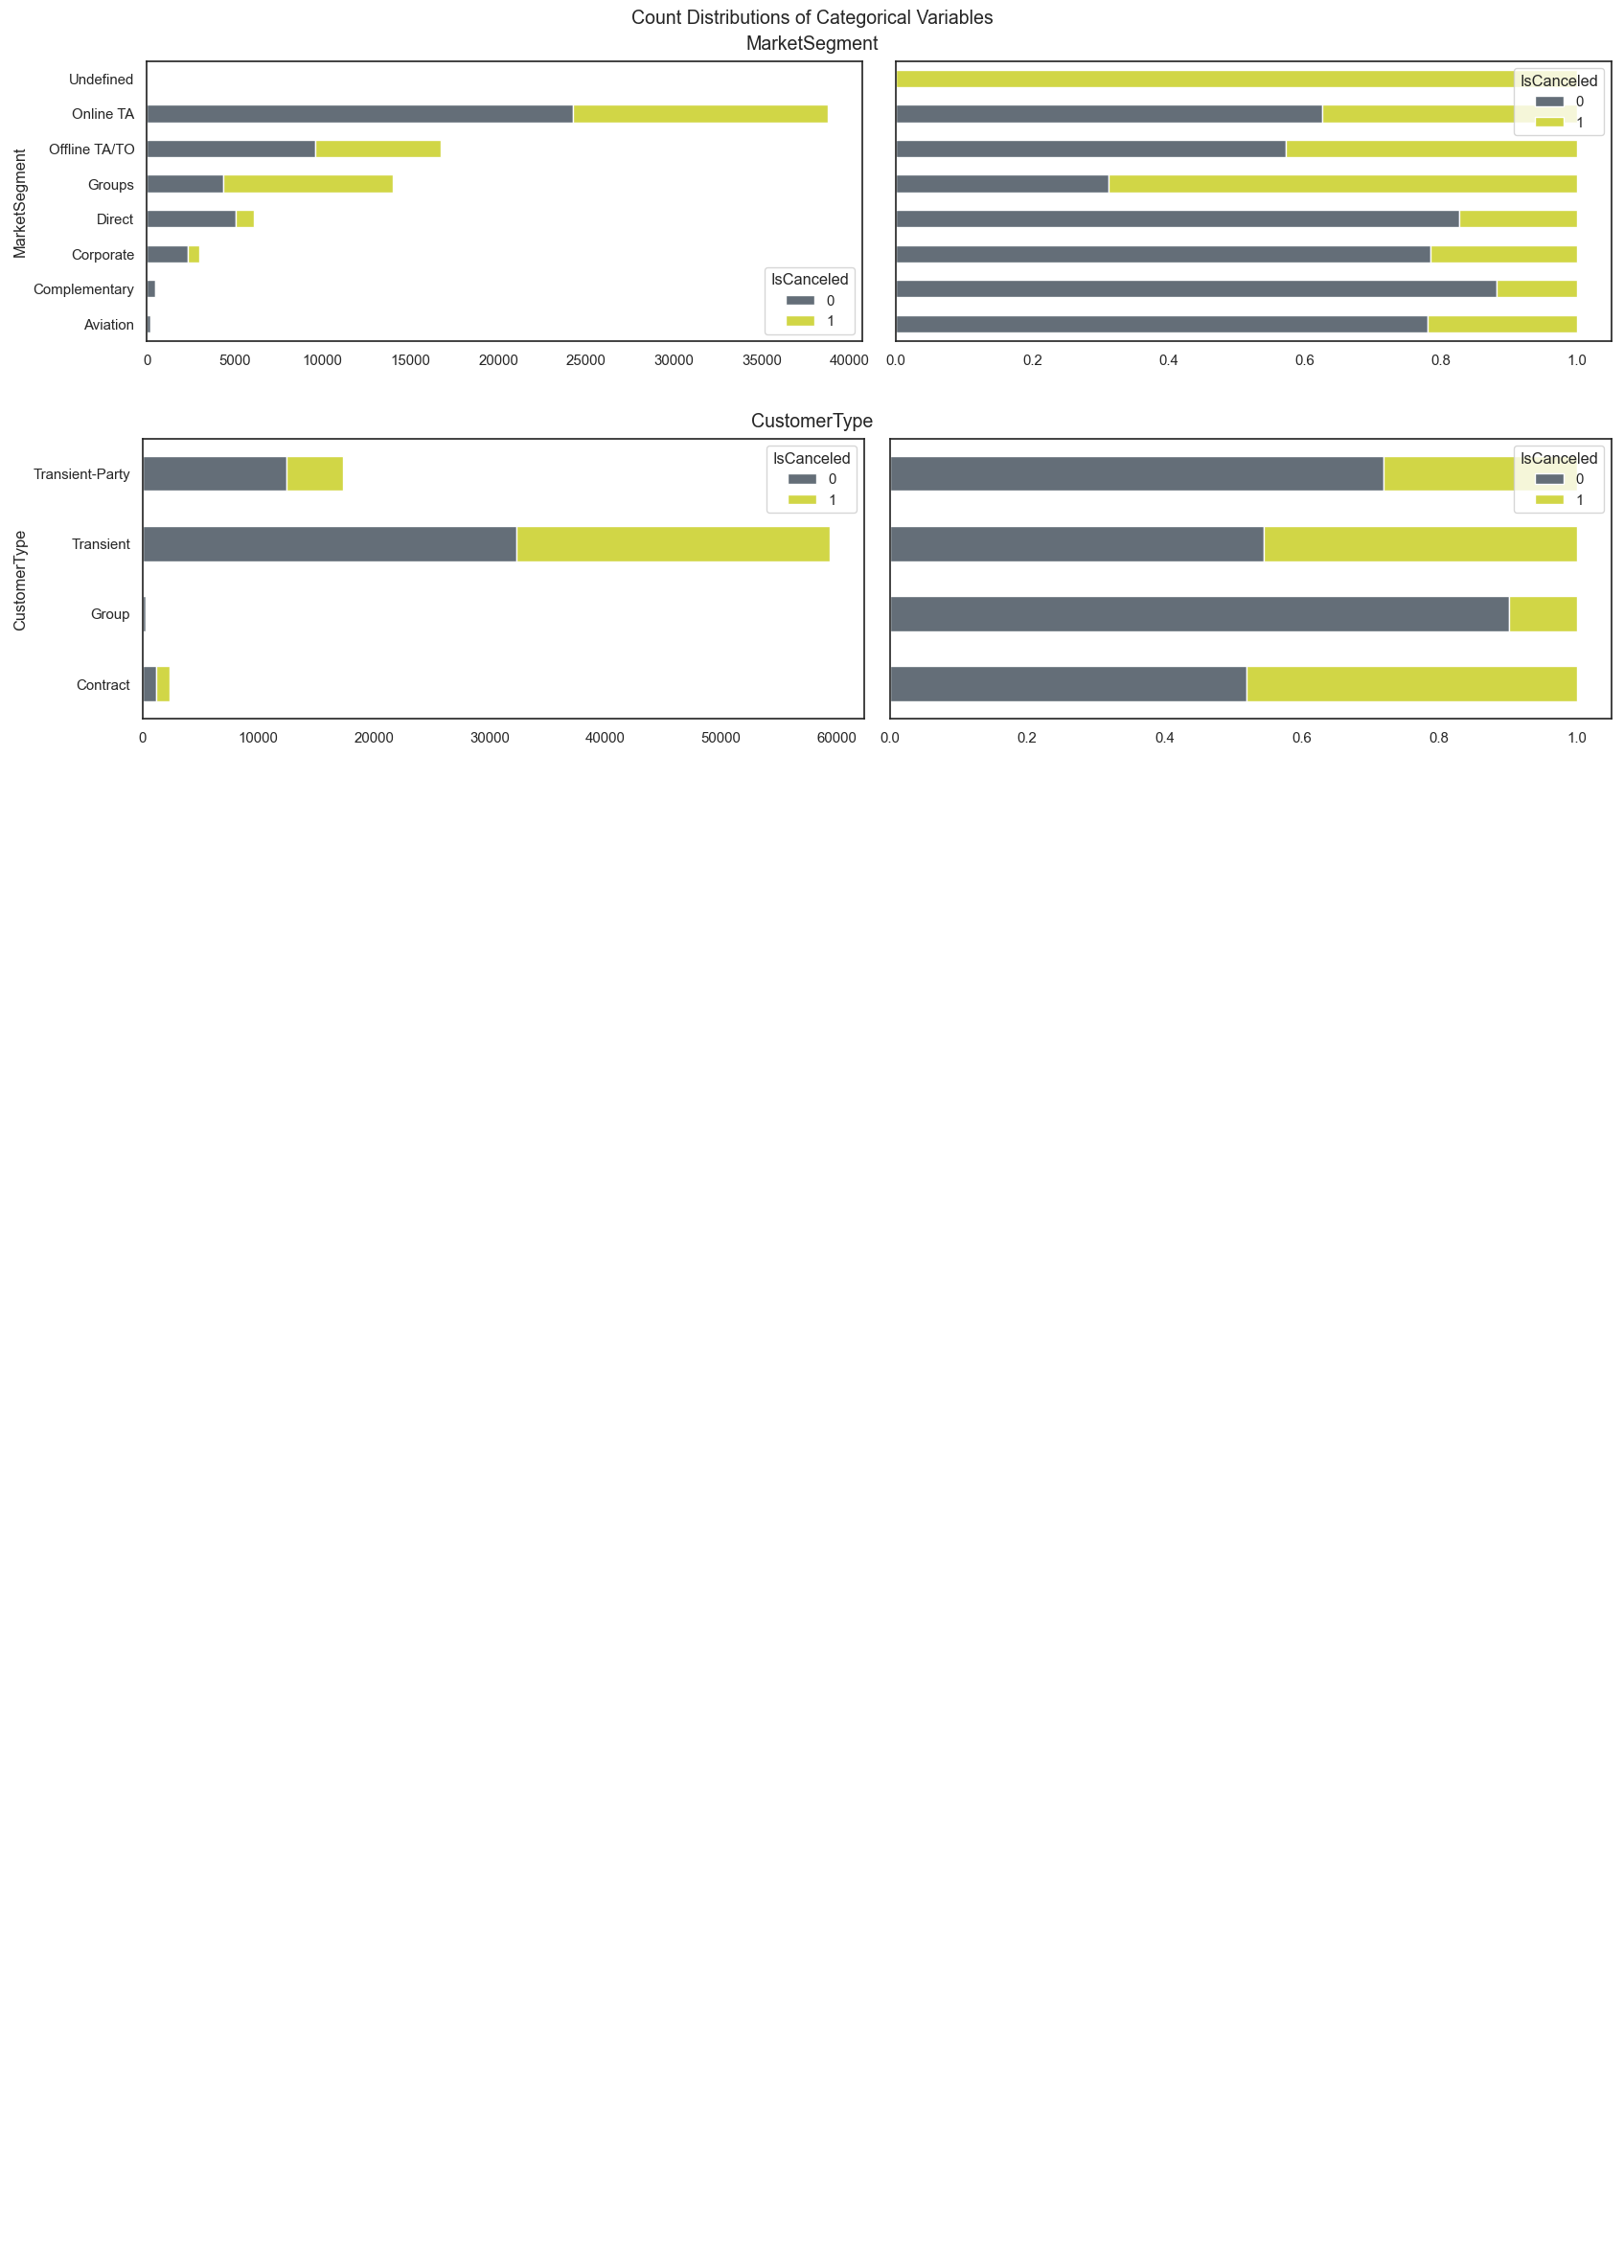

In [128]:
to_plot = ['MarketSegment', 'CustomerType']

plot_cat_counts(data, to_plot)

<b> Categorical Features that show they might be important for the model: </b> IsRoomChanged, DepositType, IsRepeatedGuest, CustomerType, DistributionChannel, MarketSegment

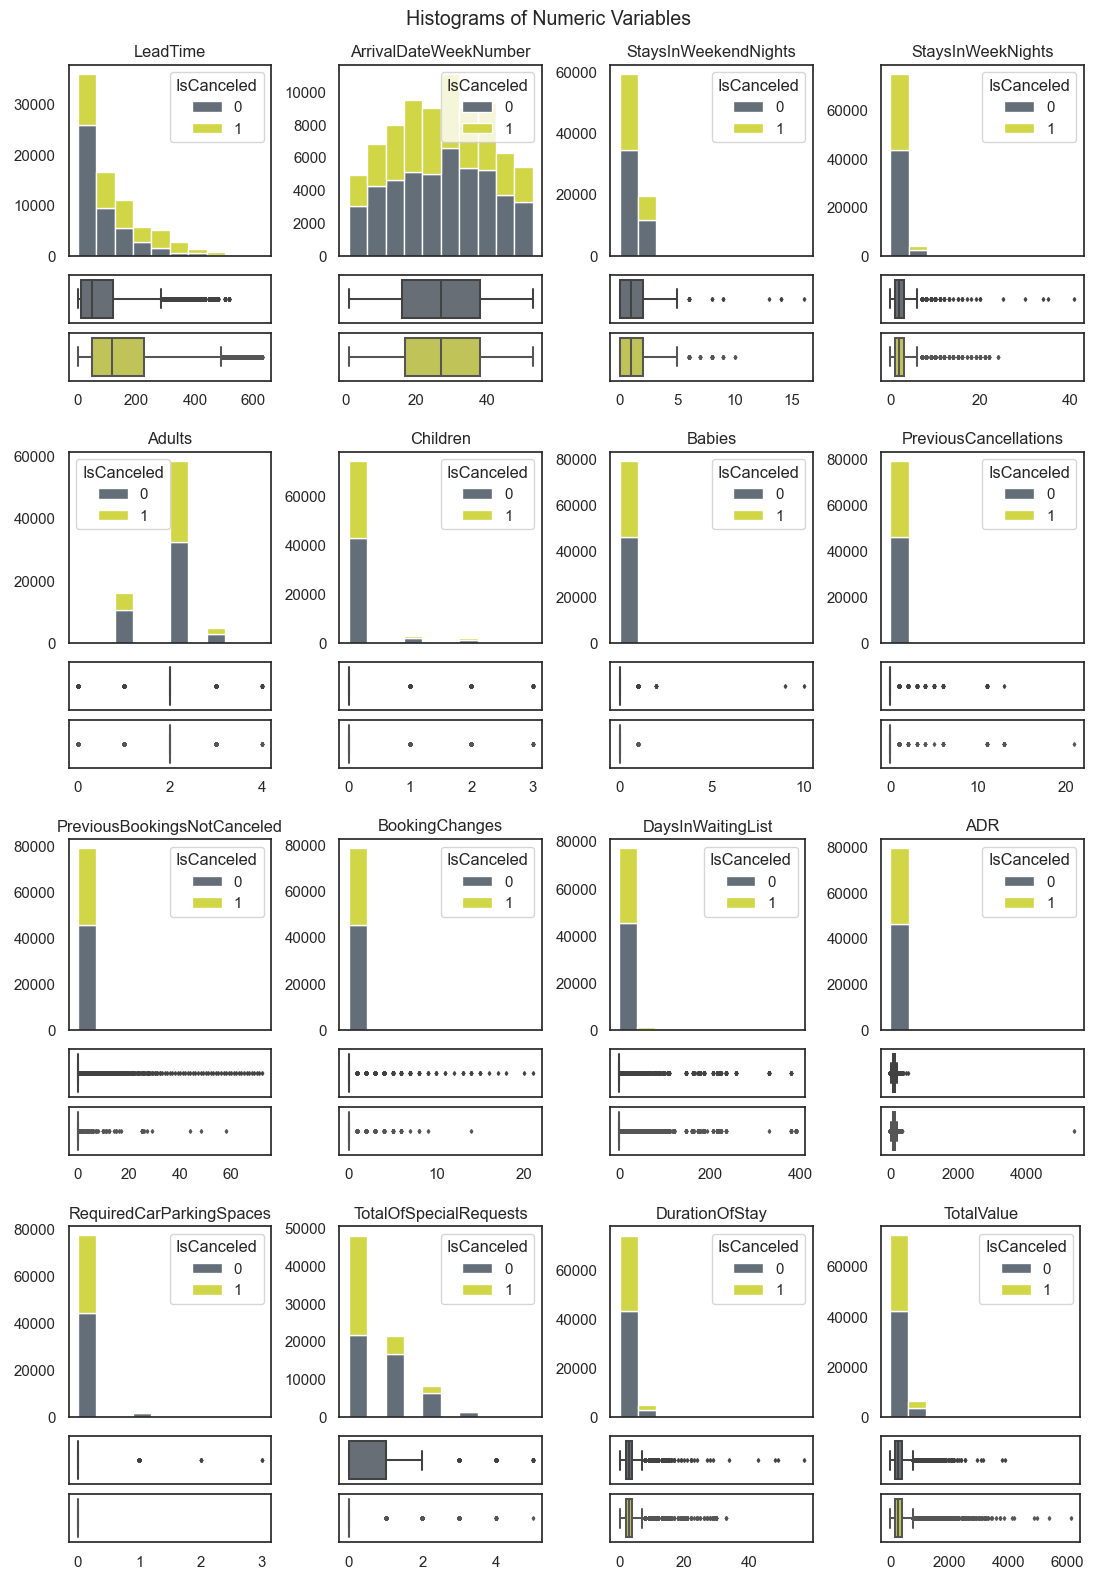

In [178]:
plot_histograms_boxplots(data, metric_features)

<b> Metric Features that show they might be important for the model: </b> LeadTime, TotalOfSpecialRequests

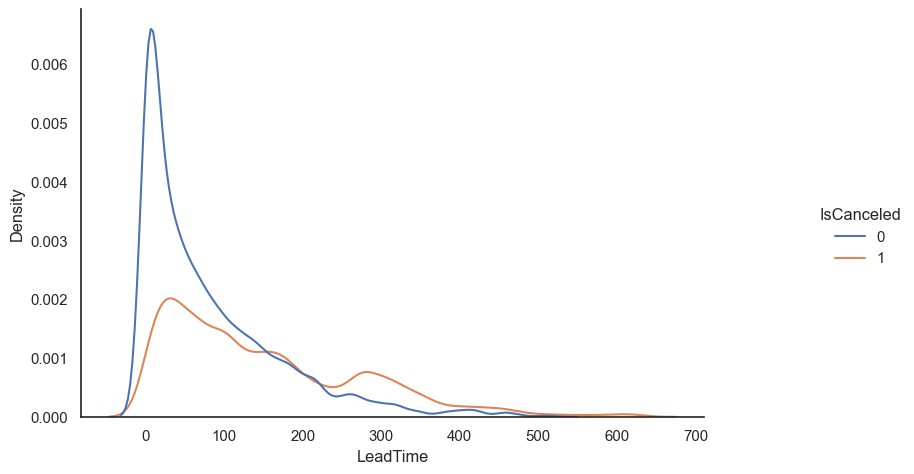

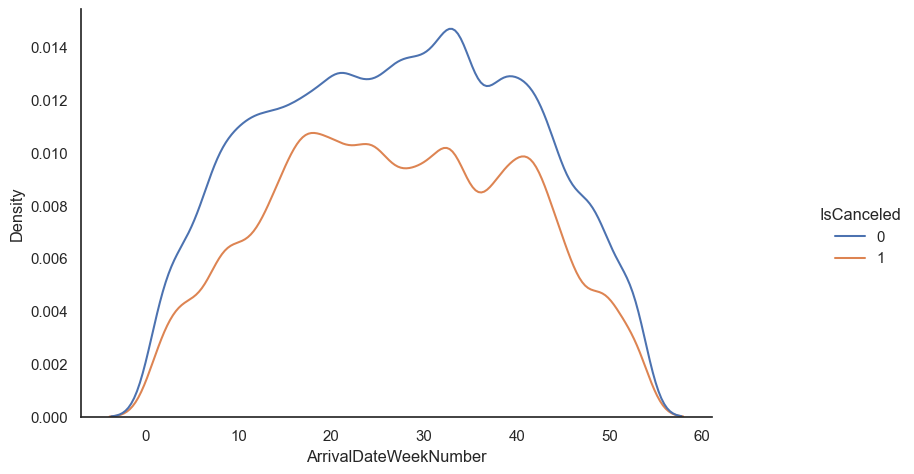

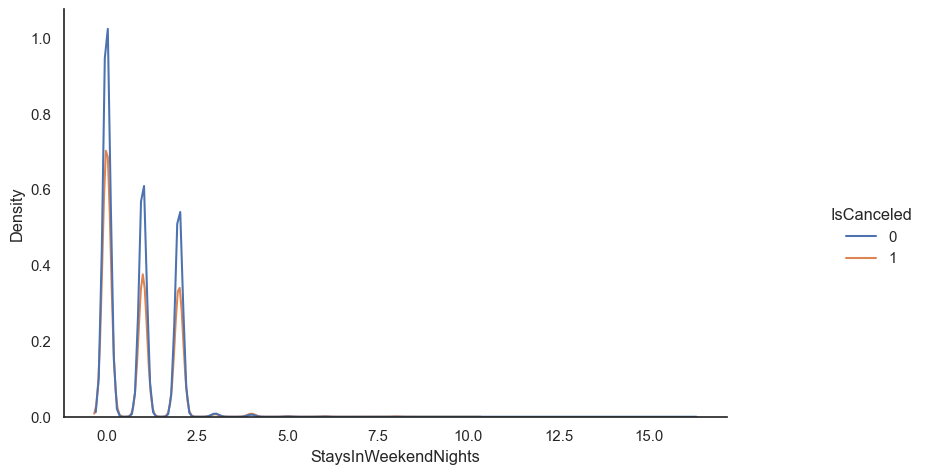

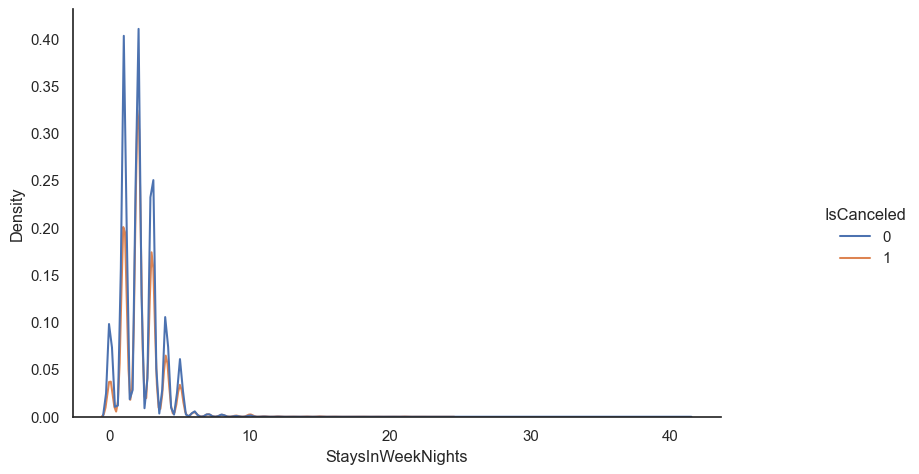

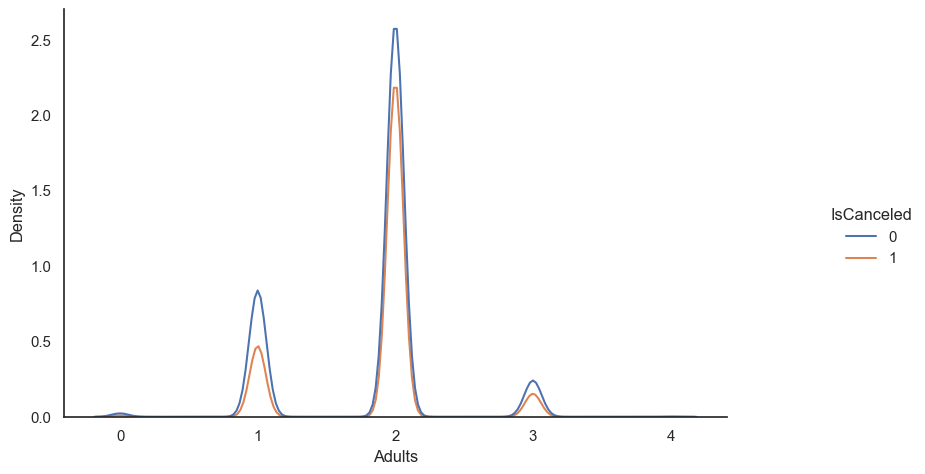

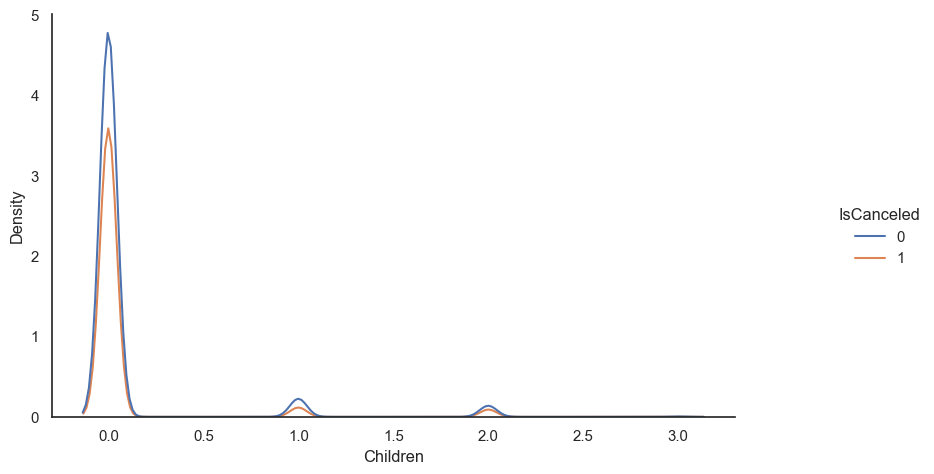

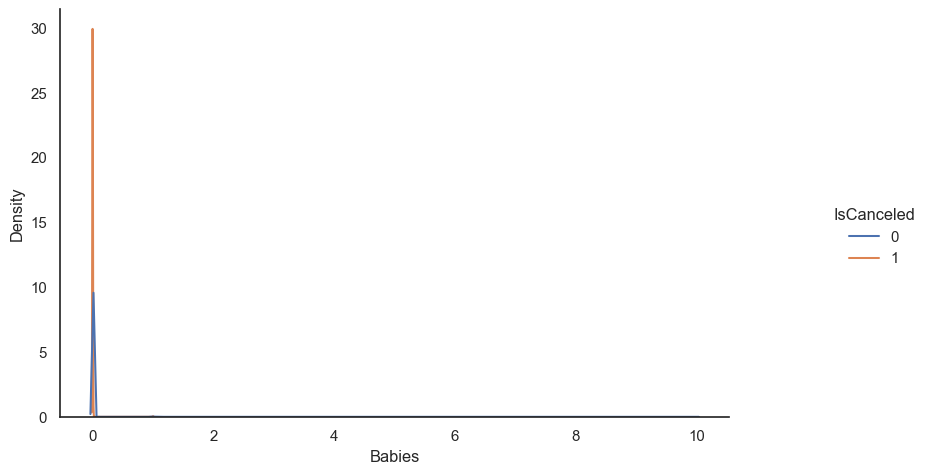

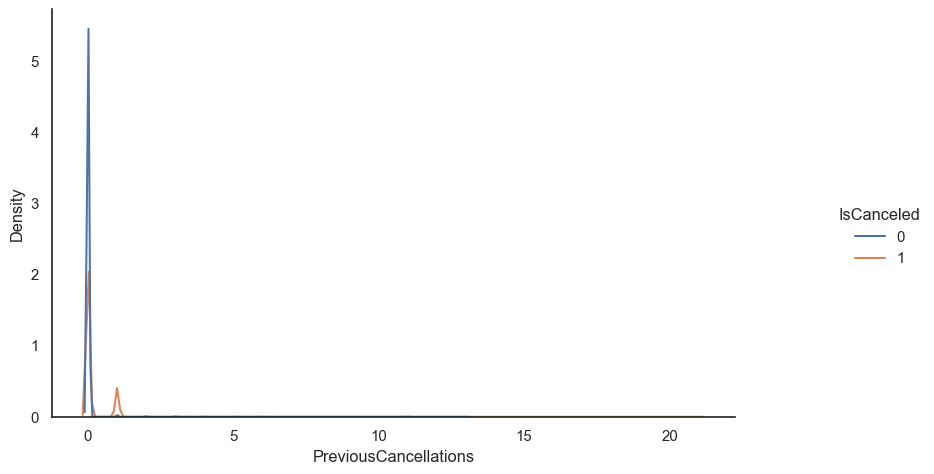

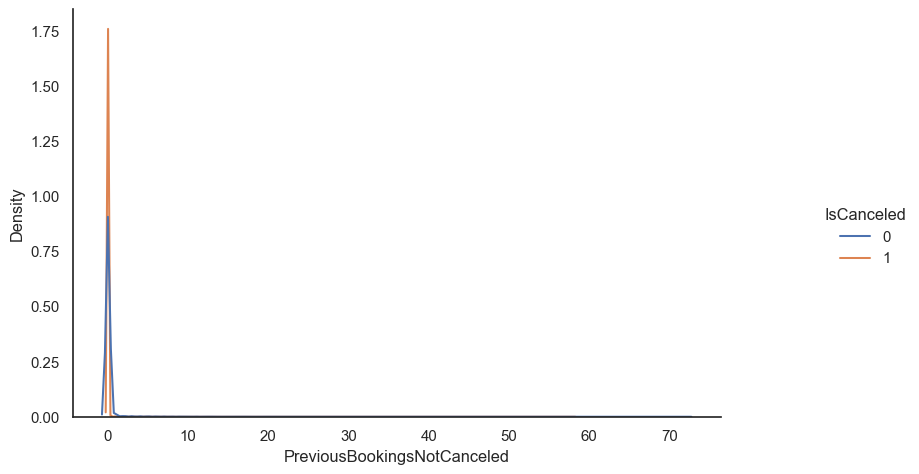

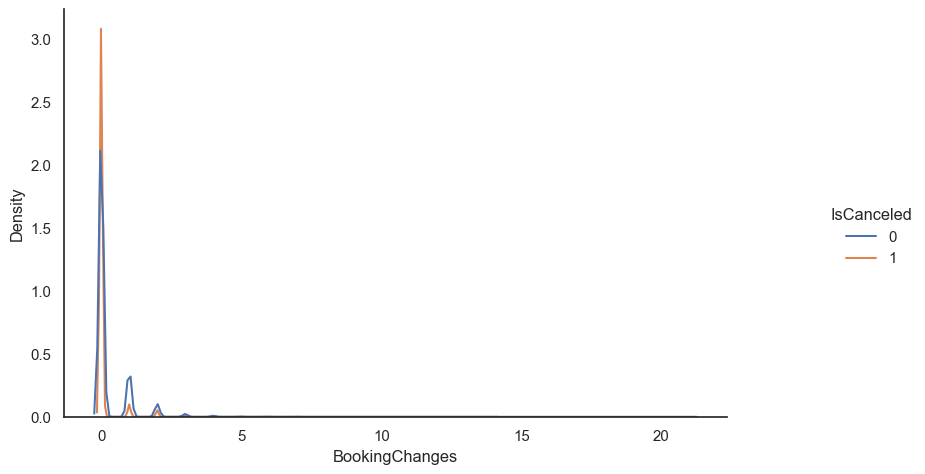

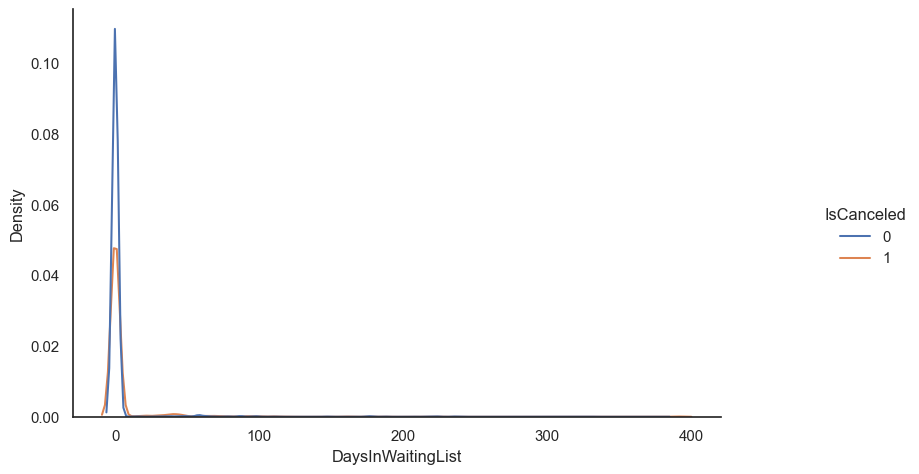

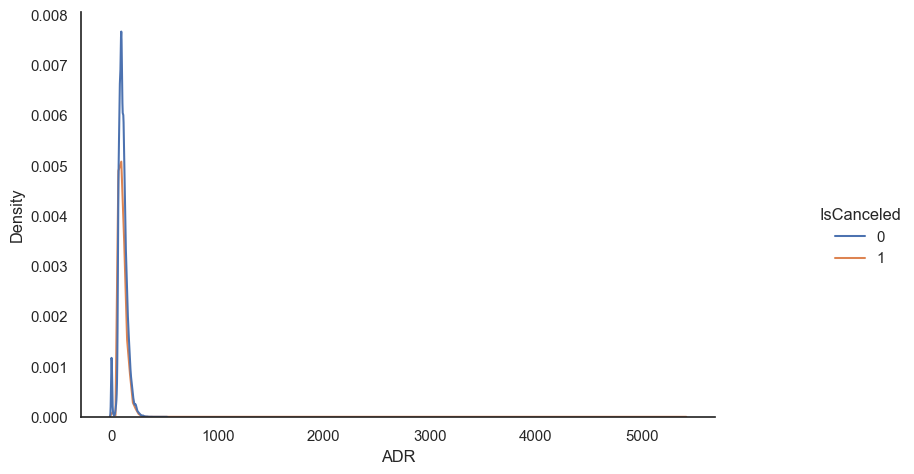

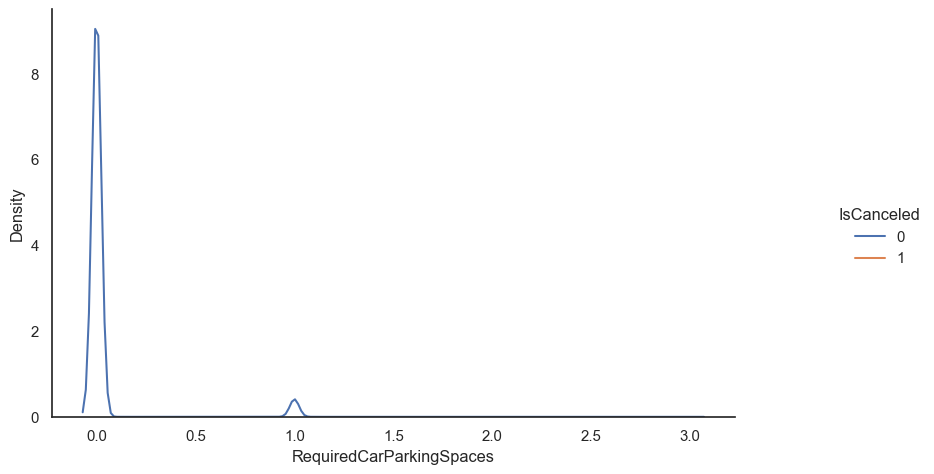

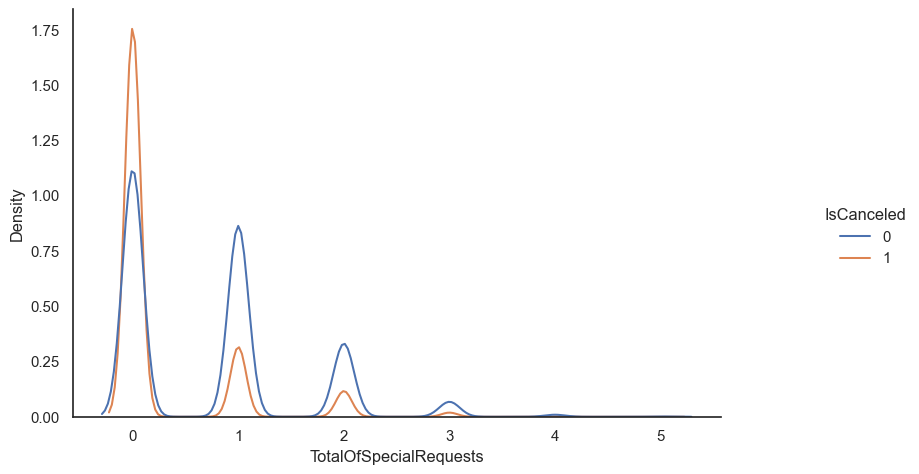

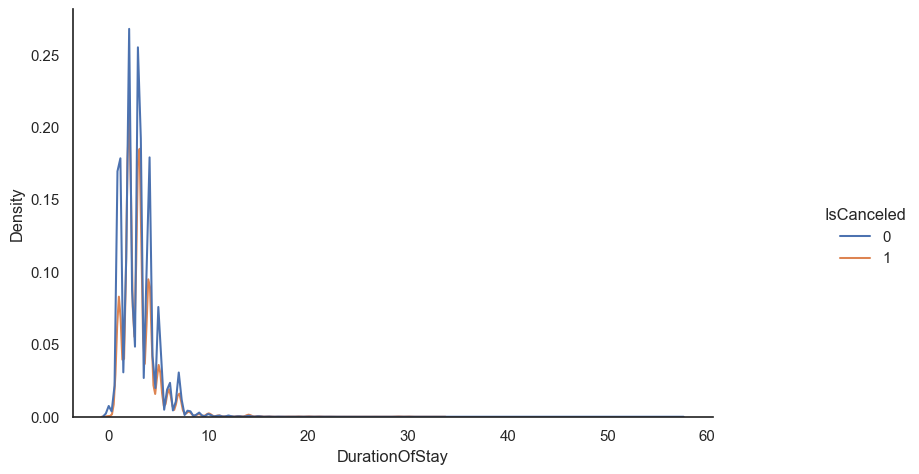

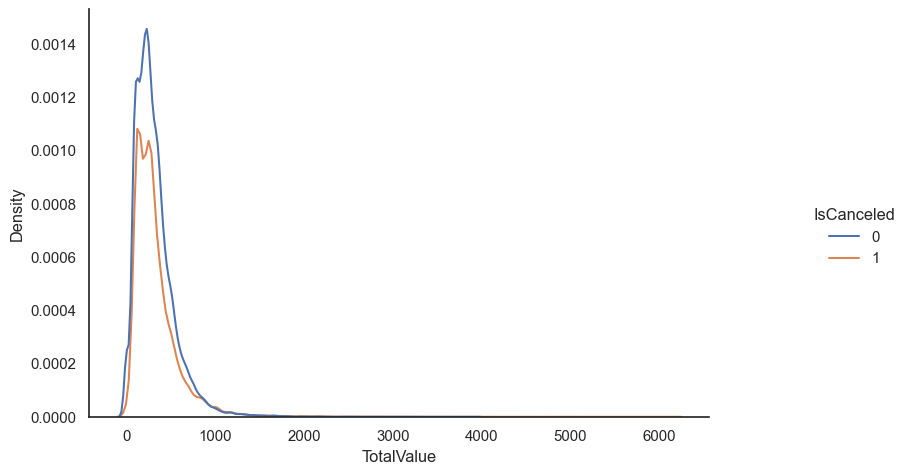

In [179]:
for feature in metric_features:
    g = sns.displot(data=data, x=feature, hue="IsCanceled", kind="kde");
    g.fig.set_size_inches(10,5)

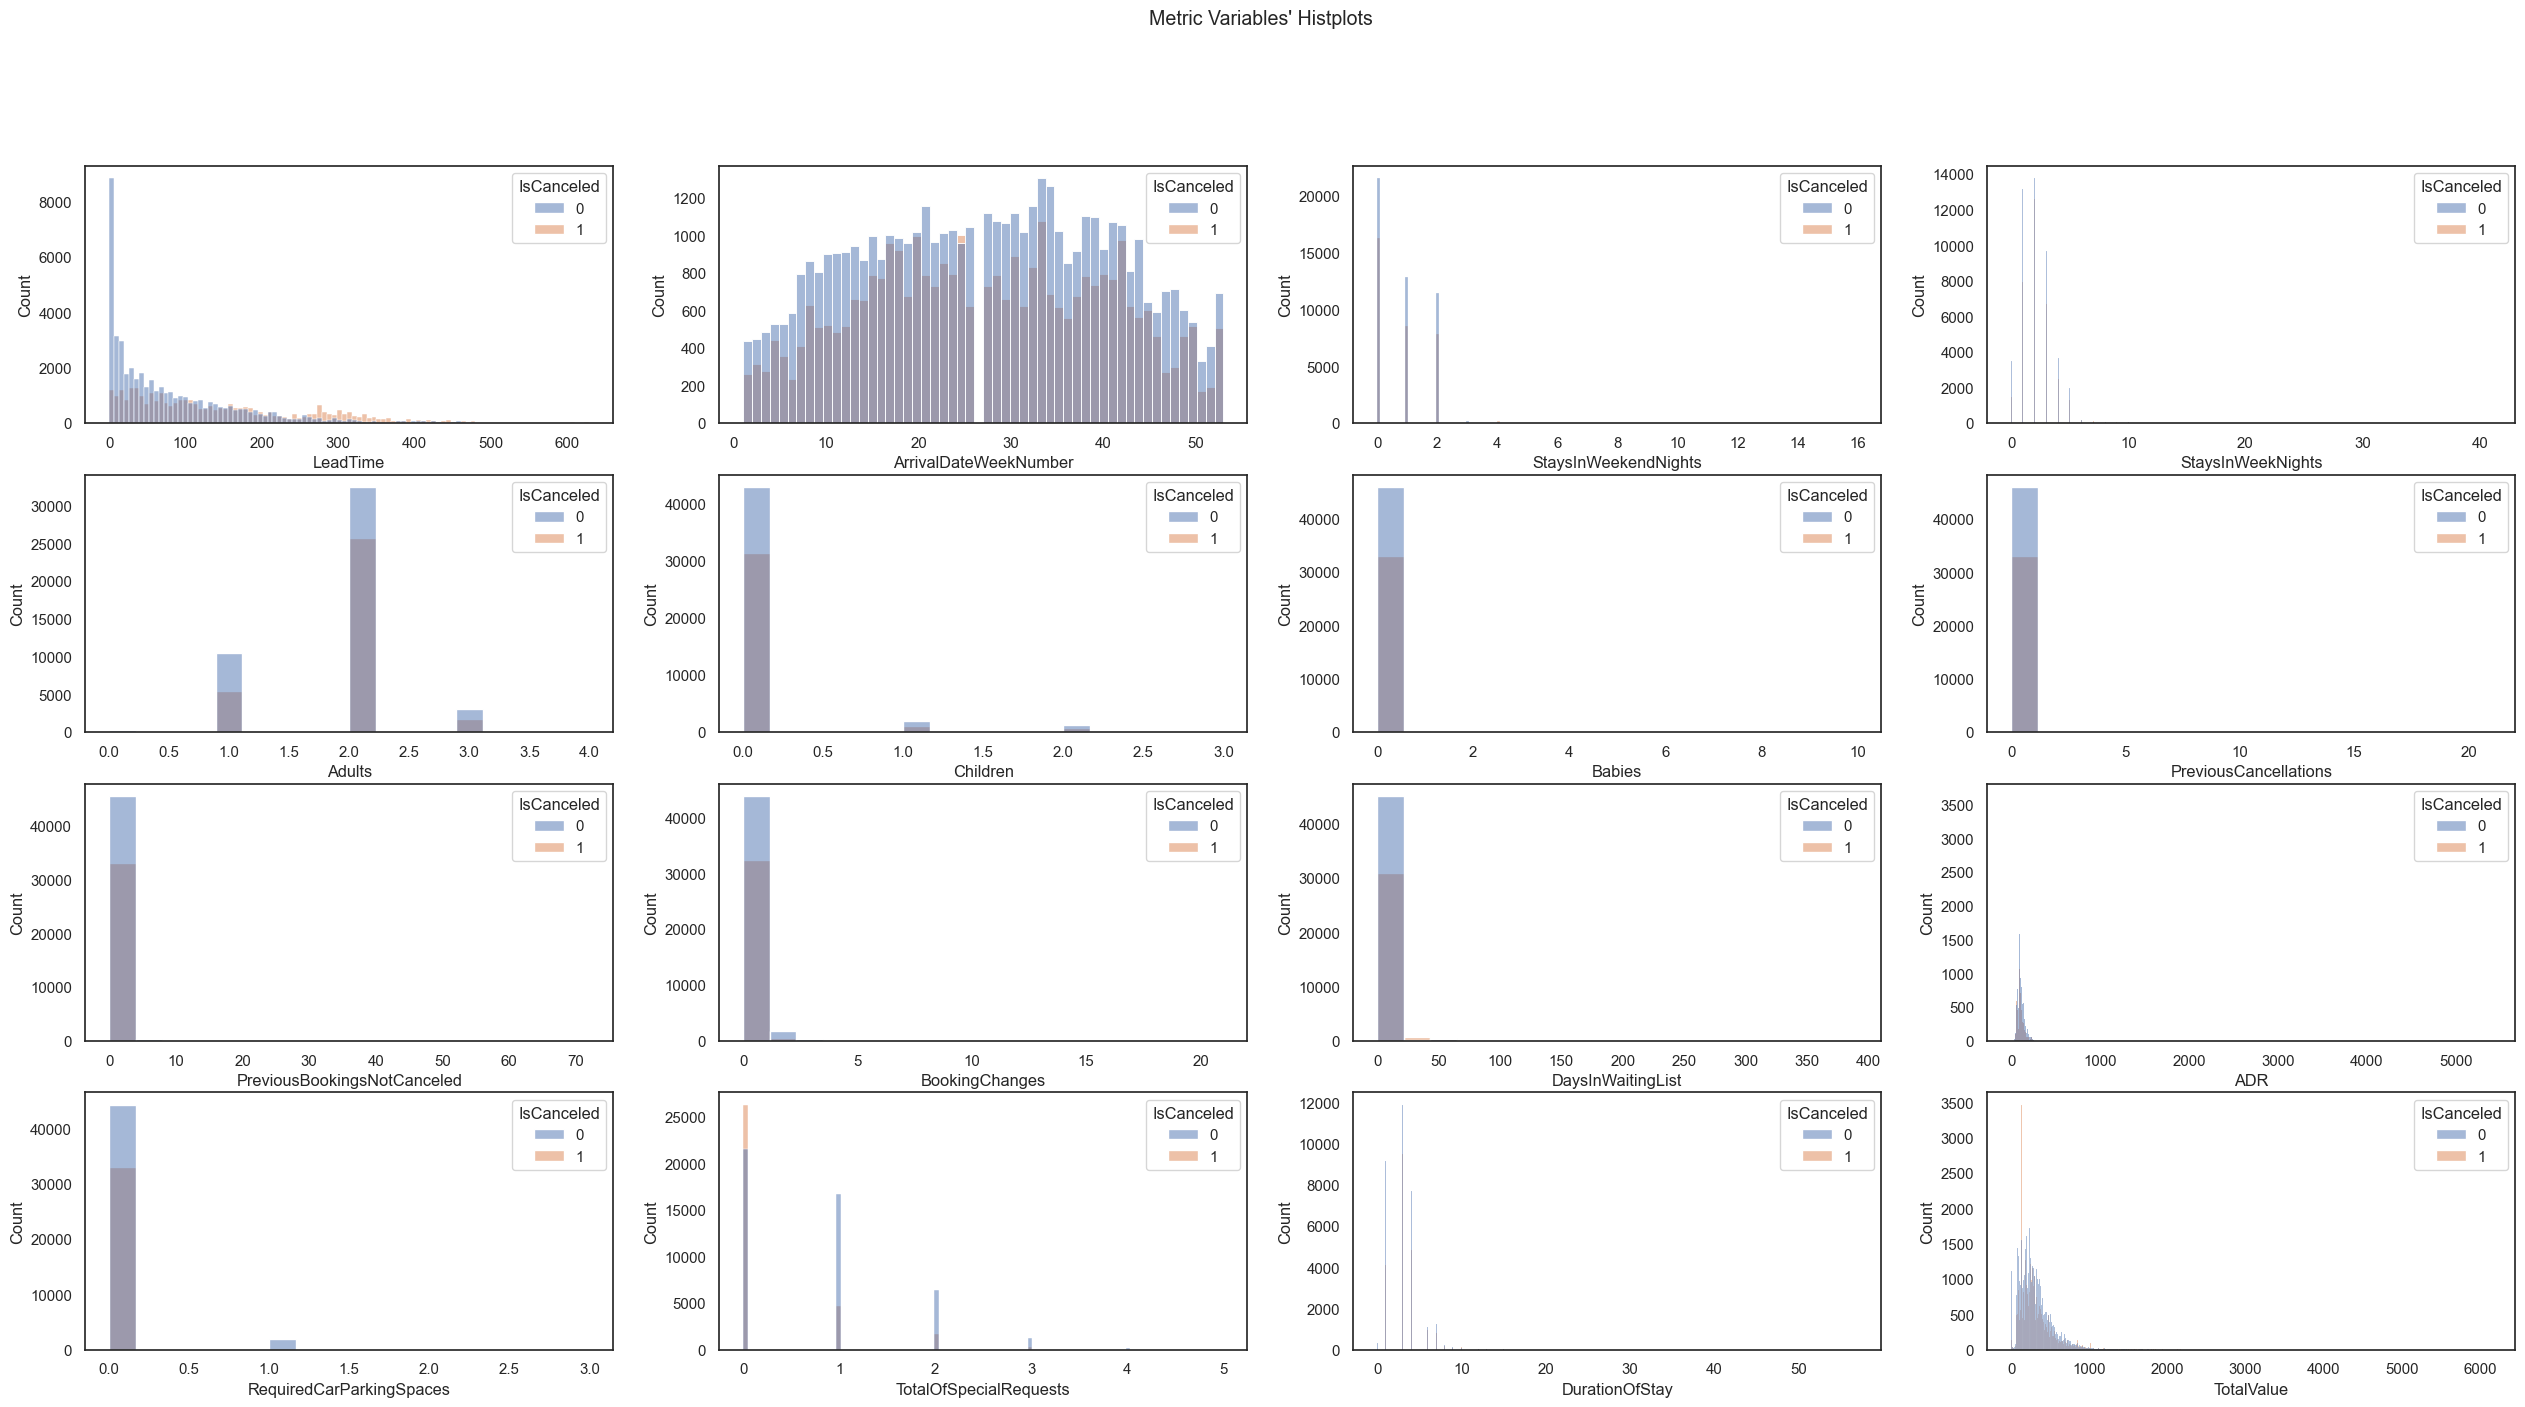

In [180]:
sns.set(style='white')

fig, axes = plt.subplots(4, ceil(len(metric_features) / 4), figsize=(32, 16))

for ax, feat in zip(axes.flatten(), metric_features):
    # sns.histplot(data[feat], ax=ax, hue = "IsCanceled")
    sns.histplot(data=data, x=feat, hue="IsCanceled", ax = ax)
    # ax.set_title(feat, y=-0.11)

title = "Metric Variables' Histplots"
plt.suptitle(title)
plt.show()

In [181]:
# Trying to understand the average room economic value
data.groupby("ReservedRoomType")["ADR"].count()

ReservedRoomType
A                   62595
B                    1115
C                      14
D                   11768
E                    1553
F                    1791
G                     484
P                      10
Name: ADR, dtype: int64

In [182]:
data[(data["AssignedRoomType"] == "P               ")]
# data.ReservedRoomType.unique()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
20591,1,0,2016,47,17,4,11,0,0,0,SC,PRT,Corporate,Direct,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2016-11-17,15,0.0,11,2016-11-17,3,17,46,11,3,0
21184,1,0,2016,50,6,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2016-12-06,0,0.0,12,2016-12-06,1,6,49,12,1,0
21185,1,0,2016,50,6,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2016-12-06,0,0.0,12,2016-12-06,1,6,49,12,1,0
21189,1,0,2016,50,6,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2016-12-06,0,0.0,12,2016-12-06,1,6,49,12,1,0
25847,1,0,2017,15,10,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2017-04-10,0,0.0,4,2017-04-10,0,10,15,4,0,0
25848,1,0,2017,15,10,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2017-04-10,0,0.0,4,2017-04-10,0,10,15,4,0,0
25849,1,0,2017,15,10,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2017-04-10,0,0.0,4,2017-04-10,0,10,15,4,0,0
25850,1,0,2017,15,10,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2017-04-10,0,0.0,4,2017-04-10,0,10,15,4,0,0
32907,1,0,2017,32,11,0,0,0,0,0,SC,PRT,Online TA,TA/TO,0,0,0,P,P,0,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Canceled,2017-08-11,0,0.0,8,2017-08-11,4,11,32,8,4,0
32908,1,0,2017,32,11,0,0,0,0,0,SC,PRT,Online TA,TA/TO,0,0,0,P,P,0,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Canceled,2017-08-11,0,0.0,8,2017-08-11,4,11,32,8,4,0


In [183]:
#exploring records with ADR = 0
data.loc[data["ADR"] == 0]#.value_counts("ReservationStatus")

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
0,0,6,2015,27,1,0,2,1,0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03,2,0.0,7,2015-07-01,2,3,27,7,4,0
134,1,0,2015,29,15,0,1,2,0,0,SC,PRT,Direct,Direct,0,0,0,A,F,0,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Canceled,2015-07-15,1,0.0,7,2015-07-15,2,15,29,7,2,1
139,0,0,2015,29,15,2,5,2,0,0,SC,PRT,Direct,Direct,0,0,0,F,A,4,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-22,7,0.0,7,2015-07-15,2,22,30,7,2,1
166,0,18,2015,29,18,1,1,1,0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1,NULL,0,Transient-Party,0.0,0,0,Check-Out,2015-07-20,2,0.0,7,2015-07-18,5,20,30,7,0,0
196,0,12,2015,29,18,2,2,1,0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1,NULL,0,Transient-Party,0.0,0,0,Check-Out,2015-07-22,4,0.0,7,2015-07-18,5,22,30,7,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78571,0,78,2017,34,23,0,0,1,0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,K,7,No Deposit,98,NULL,0,Transient-Party,0.0,0,0,Check-Out,2017-08-23,0,0.0,8,2017-08-23,2,23,34,8,2,1
78702,0,1,2017,34,24,0,1,2,1,0,BB,PRT,Complementary,Direct,0,0,0,A,D,1,No Deposit,NULL,NULL,0,Transient,0.0,0,3,Check-Out,2017-08-25,1,0.0,8,2017-08-24,3,25,34,8,4,1
78903,0,1,2017,35,27,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,A,A,0,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2017-08-27,0,0.0,8,2017-08-27,6,27,34,8,6,0
79042,0,518,2017,34,26,2,1,1,0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,1,No Deposit,229,NULL,0,Transient-Party,0.0,0,0,Check-Out,2017-08-29,3,0.0,8,2017-08-26,5,29,35,8,1,0


In [184]:
#the same day different rooms have different ADRs
data.loc[(data["ArrivalDateYear"] == 2015) &
(data["ArrivalDateMonthNumber"] == 9) & 
(data["ArrivalDateDayOfMonth"] == 2)].sort_values("ADR")

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged


In [185]:
# data.loc[(data["ADR"] == 0) & (data["MarketSegment"] != "Complementary")]
data.loc[(data["ADR"] == 0)].value_counts("MarketSegment")
# TODO: Visualization

MarketSegment
Complementary    508
Offline TA/TO    236
Online TA        173
Groups           144
Direct           111
Corporate         30
Aviation           6
dtype: int64

<BarContainer object of 8 artists>

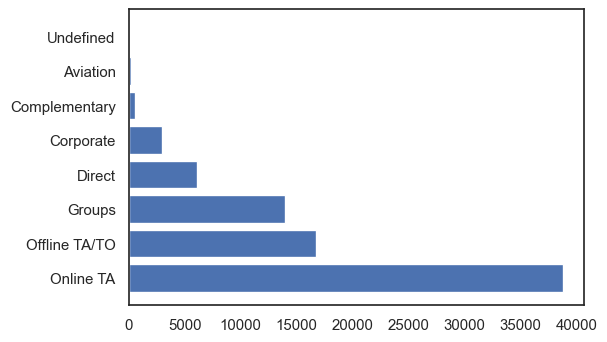

In [117]:
plt.barh(width=data['MarketSegment'].value_counts().values , y =data['MarketSegment'].value_counts().index)

In [186]:
# Complementary also have non zero ADRs
data.loc[data["MarketSegment"] == "Complementary"].sort_values("ADR", ascending = False)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
37755,0,0,2015,39,26,1,1,1,0,0,BB,PRT,Complementary,Direct,0,0,0,A,A,1,No Deposit,NULL,NULL,0,Transient,170.0,0,0,Check-Out,2015-09-28,2,340.0,9,2015-09-26,5,28,40,9,0,0
45705,0,0,2016,13,20,1,0,2,0,0,BB,DEU,Complementary,TA/TO,0,0,0,A,E,0,No Deposit,NULL,NULL,0,Transient,139.0,0,0,Check-Out,2016-03-21,1,139.0,3,2016-03-20,6,21,12,3,0,1
40489,1,8,2017,11,15,0,1,1,0,0,BB,PRT,Complementary,Direct,1,1,1,A,A,0,No Deposit,NULL,46,0,Transient,79.0,0,0,Canceled,2017-03-07,1,79.0,3,2017-03-15,2,7,10,3,1,0
40071,0,2,2015,46,9,1,2,1,0,0,BB,USA,Complementary,Direct,0,0,0,A,A,0,No Deposit,45,NULL,0,Group,79.0,0,0,Check-Out,2015-11-12,3,237.0,11,2015-11-09,0,12,46,11,3,0
61678,0,32,2016,47,15,0,2,2,0,0,BB,DEU,Complementary,Direct,0,0,0,E,E,0,No Deposit,NULL,NULL,0,Transient,75.0,0,1,Check-Out,2016-11-17,2,150.0,11,2016-11-15,1,17,46,11,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38583,1,1,2015,42,13,0,1,1,0,0,BB,PRT,Complementary,Direct,0,0,0,A,A,0,No Deposit,NULL,NULL,0,Transient,0.0,0,1,Canceled,2015-10-13,1,0.0,10,2015-10-13,1,13,42,10,1,0
38192,0,0,2016,17,21,0,1,1,0,0,BB,PRT,Complementary,Direct,1,0,1,G,G,0,No Deposit,NULL,45,0,Transient,0.0,0,0,Check-Out,2016-04-22,1,0.0,4,2016-04-21,3,22,16,4,4,0
38191,0,8,2015,41,6,0,1,1,0,0,BB,PRT,Complementary,Direct,0,0,0,A,A,0,No Deposit,NULL,45,0,Transient,0.0,0,0,Check-Out,2015-10-07,1,0.0,10,2015-10-06,1,7,41,10,2,0
38149,1,8,2015,41,6,0,1,1,0,0,BB,PRT,Complementary,Direct,0,0,0,A,A,0,No Deposit,NULL,45,0,Transient,0.0,0,0,No-Show,2015-10-06,1,0.0,10,2015-10-06,1,6,41,10,1,0


In [187]:
data.value_counts("MarketSegment")

MarketSegment
Online TA        38748
Offline TA/TO    16747
Groups           13975
Direct            6093
Corporate         2986
Complementary      542
Aviation           237
Undefined            2
dtype: int64

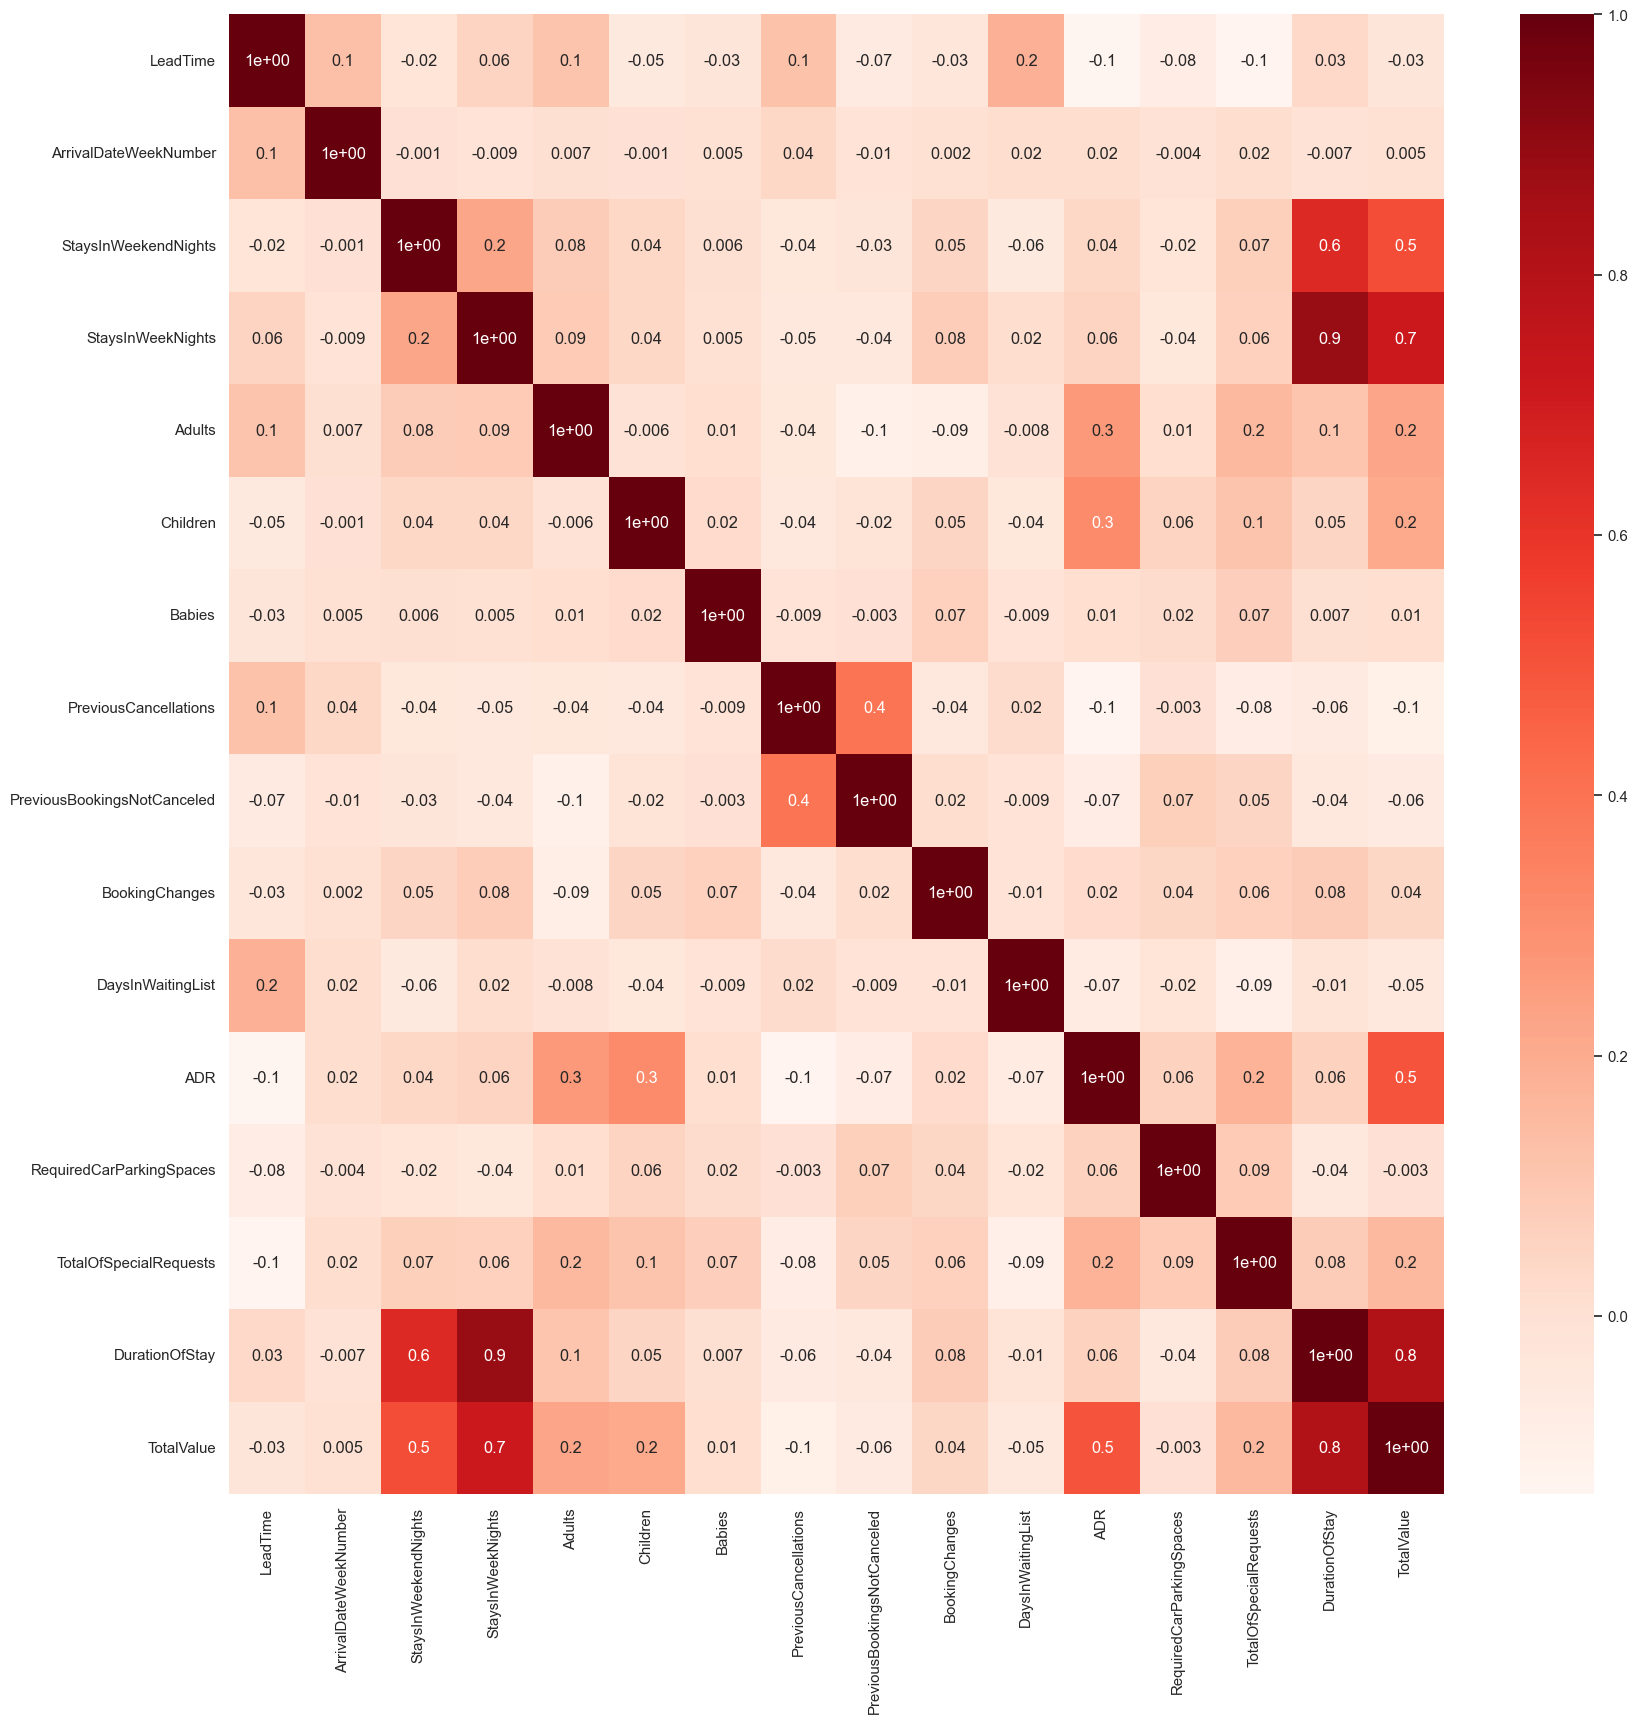

In [188]:
#TODO using pairwise relationship choose the correct correlation method (spearman vs pearsons)

def cor_heatmap(cor):
    plt.figure(figsize=(20,20))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()
    
cor_heatmap(np.round(data[metric_features].corr(),3))

## SCALING

In [189]:
data_scal = data.copy()

In [190]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(data[metric_features])
scaled_feat

array([[-0.93499555, -0.01324398, -0.89849263, ..., -0.70048417,
        -0.52505691, -1.30303449],
       [-0.19590942, -0.01324398, -0.89849263, ...,  0.58030061,
         0.5485233 , -0.0517766 ],
       [-0.40321407, -0.01324398, -0.89849263, ...,  0.58030061,
         0.5485233 , -0.19080526],
       ...,
       [-0.68262468,  0.58384053,  1.36134125, ...,  4.42265495,
         2.15889361,  3.21118501],
       [-0.00663126,  0.58384053,  1.36134125, ..., -0.70048417,
         2.15889361,  1.68526375],
       [ 0.85864031,  0.58384053,  1.36134125, ...,  1.86108539,
         3.23247382,  4.26138292]])

In [191]:
data_scal[metric_features] = scaled_feat
data_scal.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
0,0,-0.934996,2015,-0.013244,1,-0.898493,-0.125622,-1.670911,-0.245496,-0.058601,HB,PRT,Offline TA/TO,TA/TO,0,-0.191934,-0.078169,A,A,-0.307861,No Deposit,6,NULL,-0.154607,Transient,-2.415092,-0.157286,-0.700484,Check-Out,2015-07-03,-0.525057,-1.303034,7,2015-07-01,2,3,27,7,4,0
1,1,-0.195909,2015,-0.013244,1,-0.898493,1.247620,0.292610,-0.245496,-0.058601,BB,PRT,Online TA,TA/TO,0,-0.191934,-0.078169,A,A,-0.307861,No Deposit,9,NULL,-0.154607,Transient,-0.660612,-0.157286,0.580301,Canceled,2015-07-01,0.548523,-0.051777,7,2015-07-01,2,1,27,7,2,0
2,1,-0.403214,2015,-0.013244,1,-0.898493,1.247620,-1.670911,-0.245496,-0.058601,BB,PRT,Online TA,TA/TO,0,-0.191934,-0.078169,A,A,-0.307861,No Deposit,9,NULL,-0.154607,Transient,-0.855554,-0.157286,0.580301,Canceled,2015-04-30,0.548523,-0.190805,7,2015-07-01,2,30,18,4,3,0
3,1,-0.159856,2015,-0.013244,1,1.361341,1.247620,0.292610,-0.245496,-0.058601,BB,PRT,Online TA,TA/TO,0,-0.191934,-0.078169,A,A,-0.307861,No Deposit,9,NULL,-0.154607,Transient,-0.660612,-0.157286,1.861085,Canceled,2015-06-23,1.622104,0.573852,7,2015-07-01,2,23,26,6,1,0
4,1,-0.087750,2015,-0.013244,2,-0.898493,-0.125622,0.292610,-0.245496,-0.058601,BB,PRT,Online TA,TA/TO,0,-0.191934,-0.078169,A,A,-0.307861,No Deposit,9,NULL,-0.154607,Transient,-0.660612,-0.157286,0.580301,Canceled,2015-04-02,-0.525057,-0.677406,7,2015-07-02,3,2,14,4,3,0


In [192]:
df = data_scal.copy()

## OUTLIERS TREATEMENT

In [193]:
data_out = df.copy()
# data_out1 = data.copy()

In [194]:
# def Isolation_Forest (data):
   
    
#     #this algorithm only works with data without missing values
#     data_out = data[numeric_features]
#     #data_out = data.select_dtypes(include=np.number).set_index(data.index)
#     forest_model = IsolationForest(n_estimators=20,contamination=0.01)
#     forest_model.fit(data_out)
#     anomally = forest_model.decision_function(data_out)
#     predict_outcome = forest_model.predict(data_out)
    
#     #creating a dataset with the density scores and the predicted outcome (-1==outlier; 1==normal obs)
#     data_out_score = pd.DataFrame(data=anomally, index=data_out.index)
#     data_out_score['predicted_outcome'] = predict_outcome
#     return(data_out_score)

# def Isolation_Forest_test (data):
#     outliers = Isolation_Forest(data)
#     outliers_test = pd.DataFrame(index = data.index)
#     outliers_test['predicted_outcome'] = outliers['predicted_outcome']
#     outliers_test.loc[outliers_test['predicted_outcome']==1, 'predicted_outcome']= 0 
#     outliers_test.loc[outliers_test['predicted_outcome']==-1, 'predicted_outcome']= 1
#     return(outliers_test)

# #data_IF = Isolation_Forest(data_outliers)
# data_IF = Isolation_Forest_test(data_out)

In [195]:
# data_out["Outlier"] = data_IF["predicted_outcome"]

In [196]:
# for i in data_out.loc[:, data.select_dtypes(include=np.number).columns].columns:
#     col = np.array(data.columns)
#     col = col[col!=i]
#     for index , ii in enumerate(col):
#         plt.figure(index)
#         sns.scatterplot(data_out[i],data_out[ii],hue=data_out['Outlier'])
#         plt.show()

In [197]:
# One Class Support Vector Machine
ee = OneClassSVM(nu=0.01)
yhat = ee.fit_predict(data_out[metric_features])
# yhat1 = ee.fit_predict(data_out[numeric_features])

In [198]:
data_out['Outliers'] = yhat
# data_out1['Outliers'] = yhat1
data_out_rem= data_out[data_out['Outliers']==1]
# data_out_rem1= data_out1[data_out1['Outliers']==1]

In [ ]:
#TODO check records marked as outliers and check if they can be considered outliers

Percentage kept:  0.9878356233455187


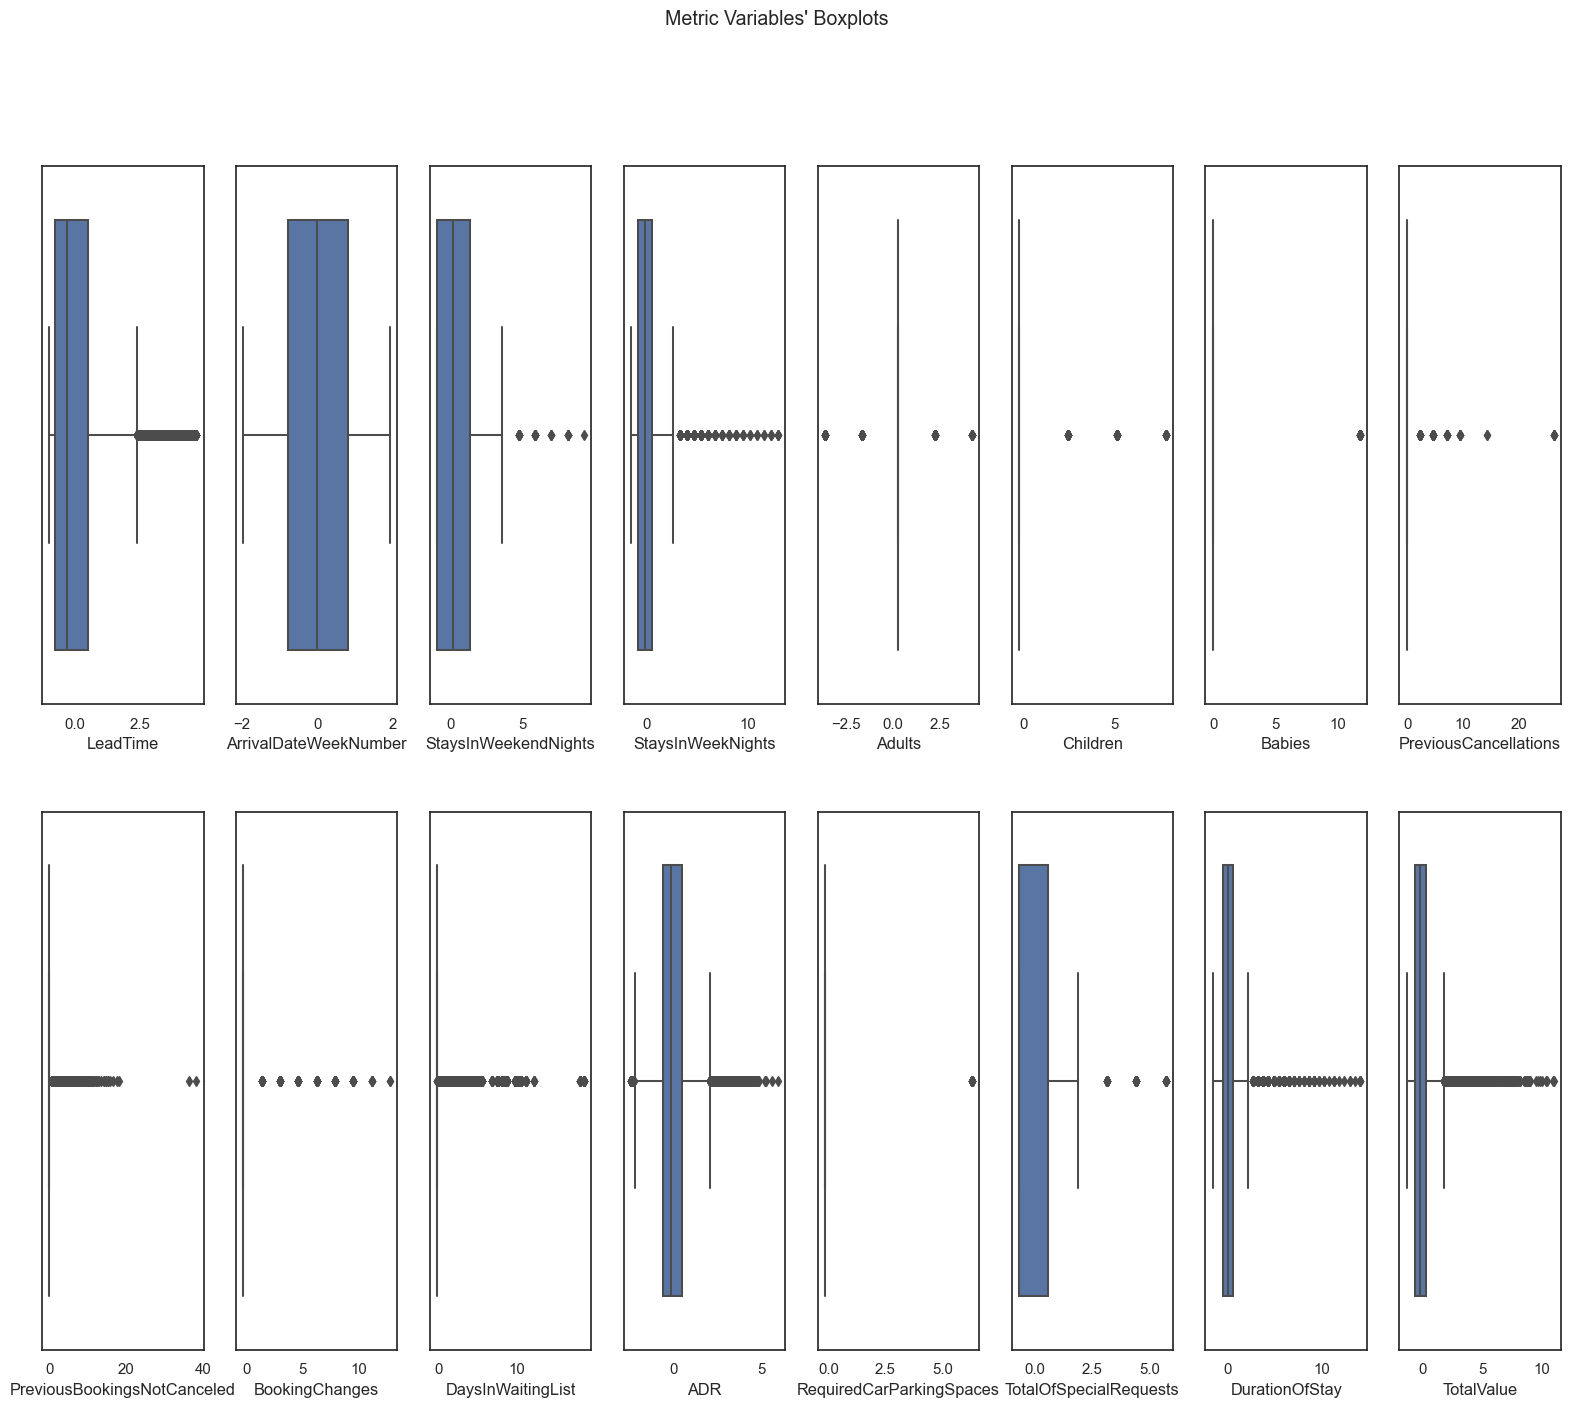

In [199]:
# print("Percentage kept: " , len(data_out_rem) / len(data_out))
# boxplot(data_out_rem, numeric_features)
# print("Percentage kept: " , len(data_out_rem1) / len(data_out1))
# boxplot(data_out_rem1, numeric_features)
print("Percentage kept: " , len(data_out_rem) / len(data_out))
boxplot(data_out_rem, metric_features)
# print("Percentage kept: " , len(data_out_rem1) / len(data_out1))
# boxplot(data_out_rem1, metric_features)

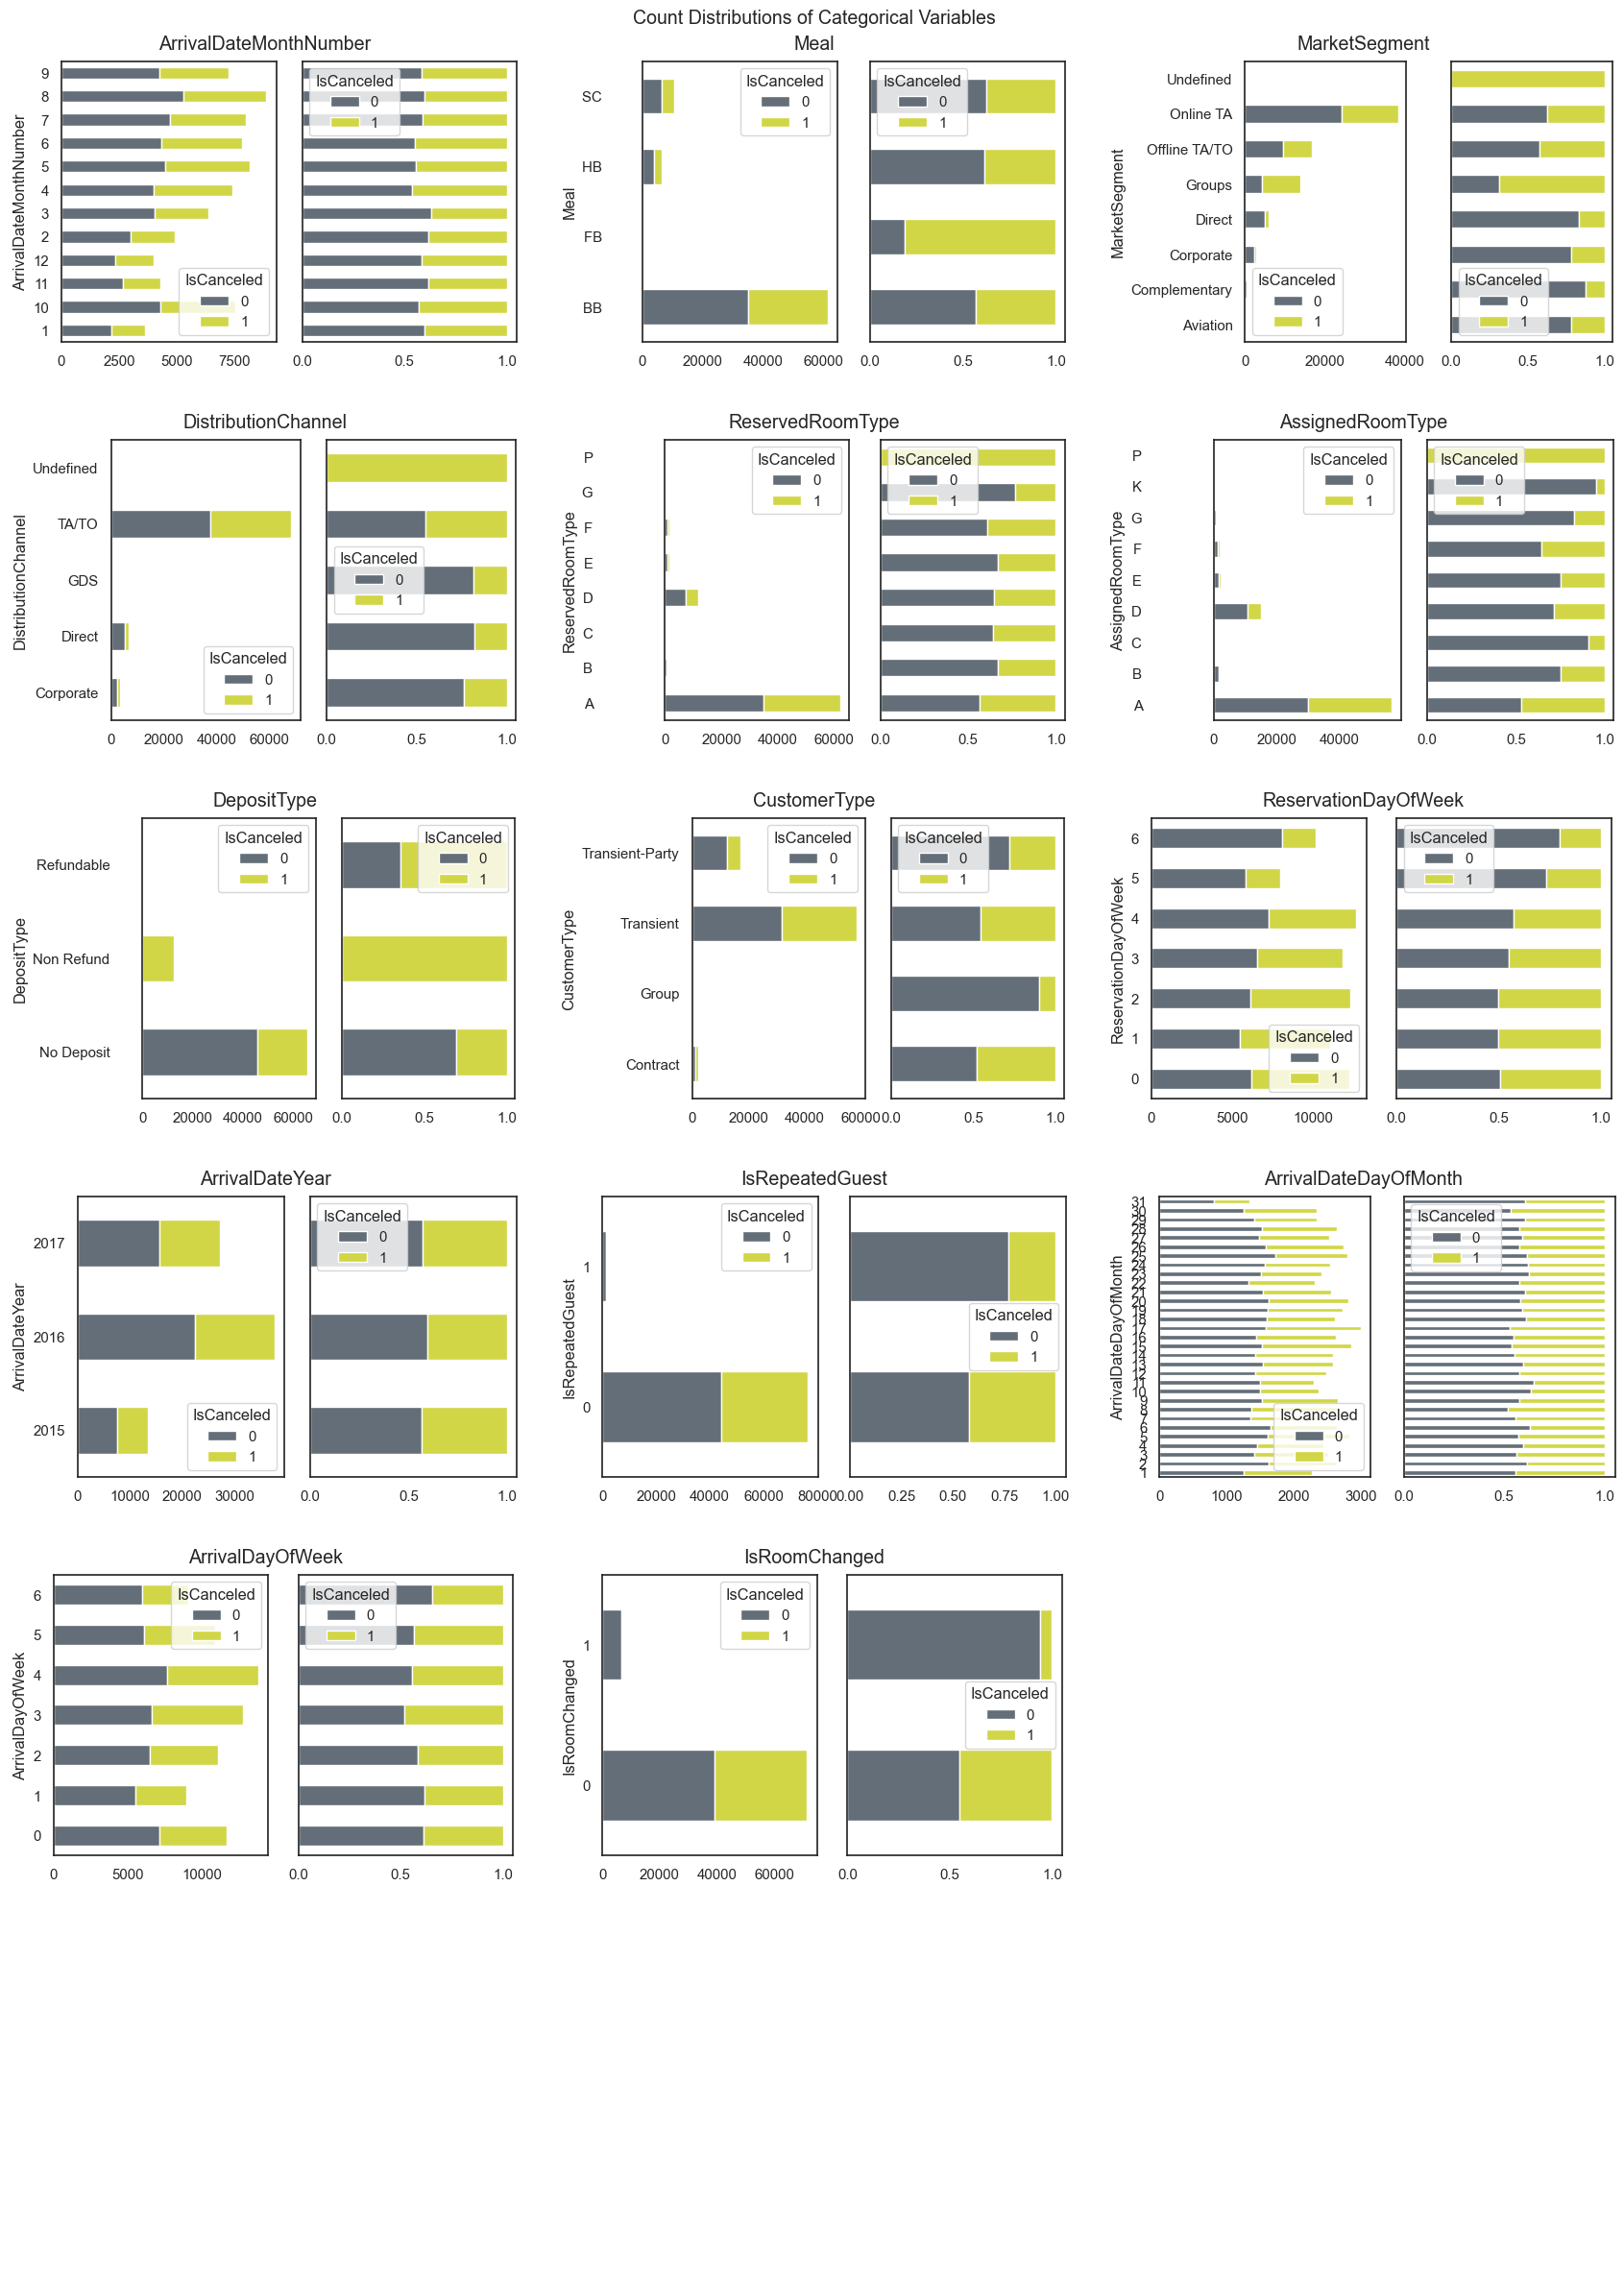

In [200]:
plot_cat_counts(data_out_rem, to_plot)

In [201]:
# For lower cardinalities, we create a Others category

In [202]:
data_out_rem["DistributionChannel"].replace(["GDS", "Undefined"], "Others", inplace=True)
data_out_rem['DistributionChannel'].value_counts()

TA/TO        68329
Direct        6575
Corporate     3265
Others         196
Name: DistributionChannel, dtype: int64

In [203]:
data_out_rem['MarketSegment'].replace(["Aviation", "Undefined", "Complementary"], "Others", inplace=True)
data_out_rem['MarketSegment'].value_counts()

Online TA        38428
Offline TA/TO    16633
Groups           13789
Direct            5949
Corporate         2851
Others             715
Name: MarketSegment, dtype: int64

In [204]:
data_out_rem['ReservedRoomType'].replace(["G               ", "C               ", "P               "], "Others", inplace=True)
data_out_rem['ReservedRoomType'].value_counts()

A                   61993
D                   11672
F                    1710
E                    1492
B                    1067
Others                431
Name: ReservedRoomType, dtype: int64

In [205]:
data_out_rem['AssignedRoomType'].replace(["G               ", "C               ", "P               ", "K               "], "Others", inplace=True)
data_out_rem['AssignedRoomType'].value_counts()

A                   56491
D                   14865
E                    2108
B                    1941
F                    1939
Others               1021
Name: AssignedRoomType, dtype: int64

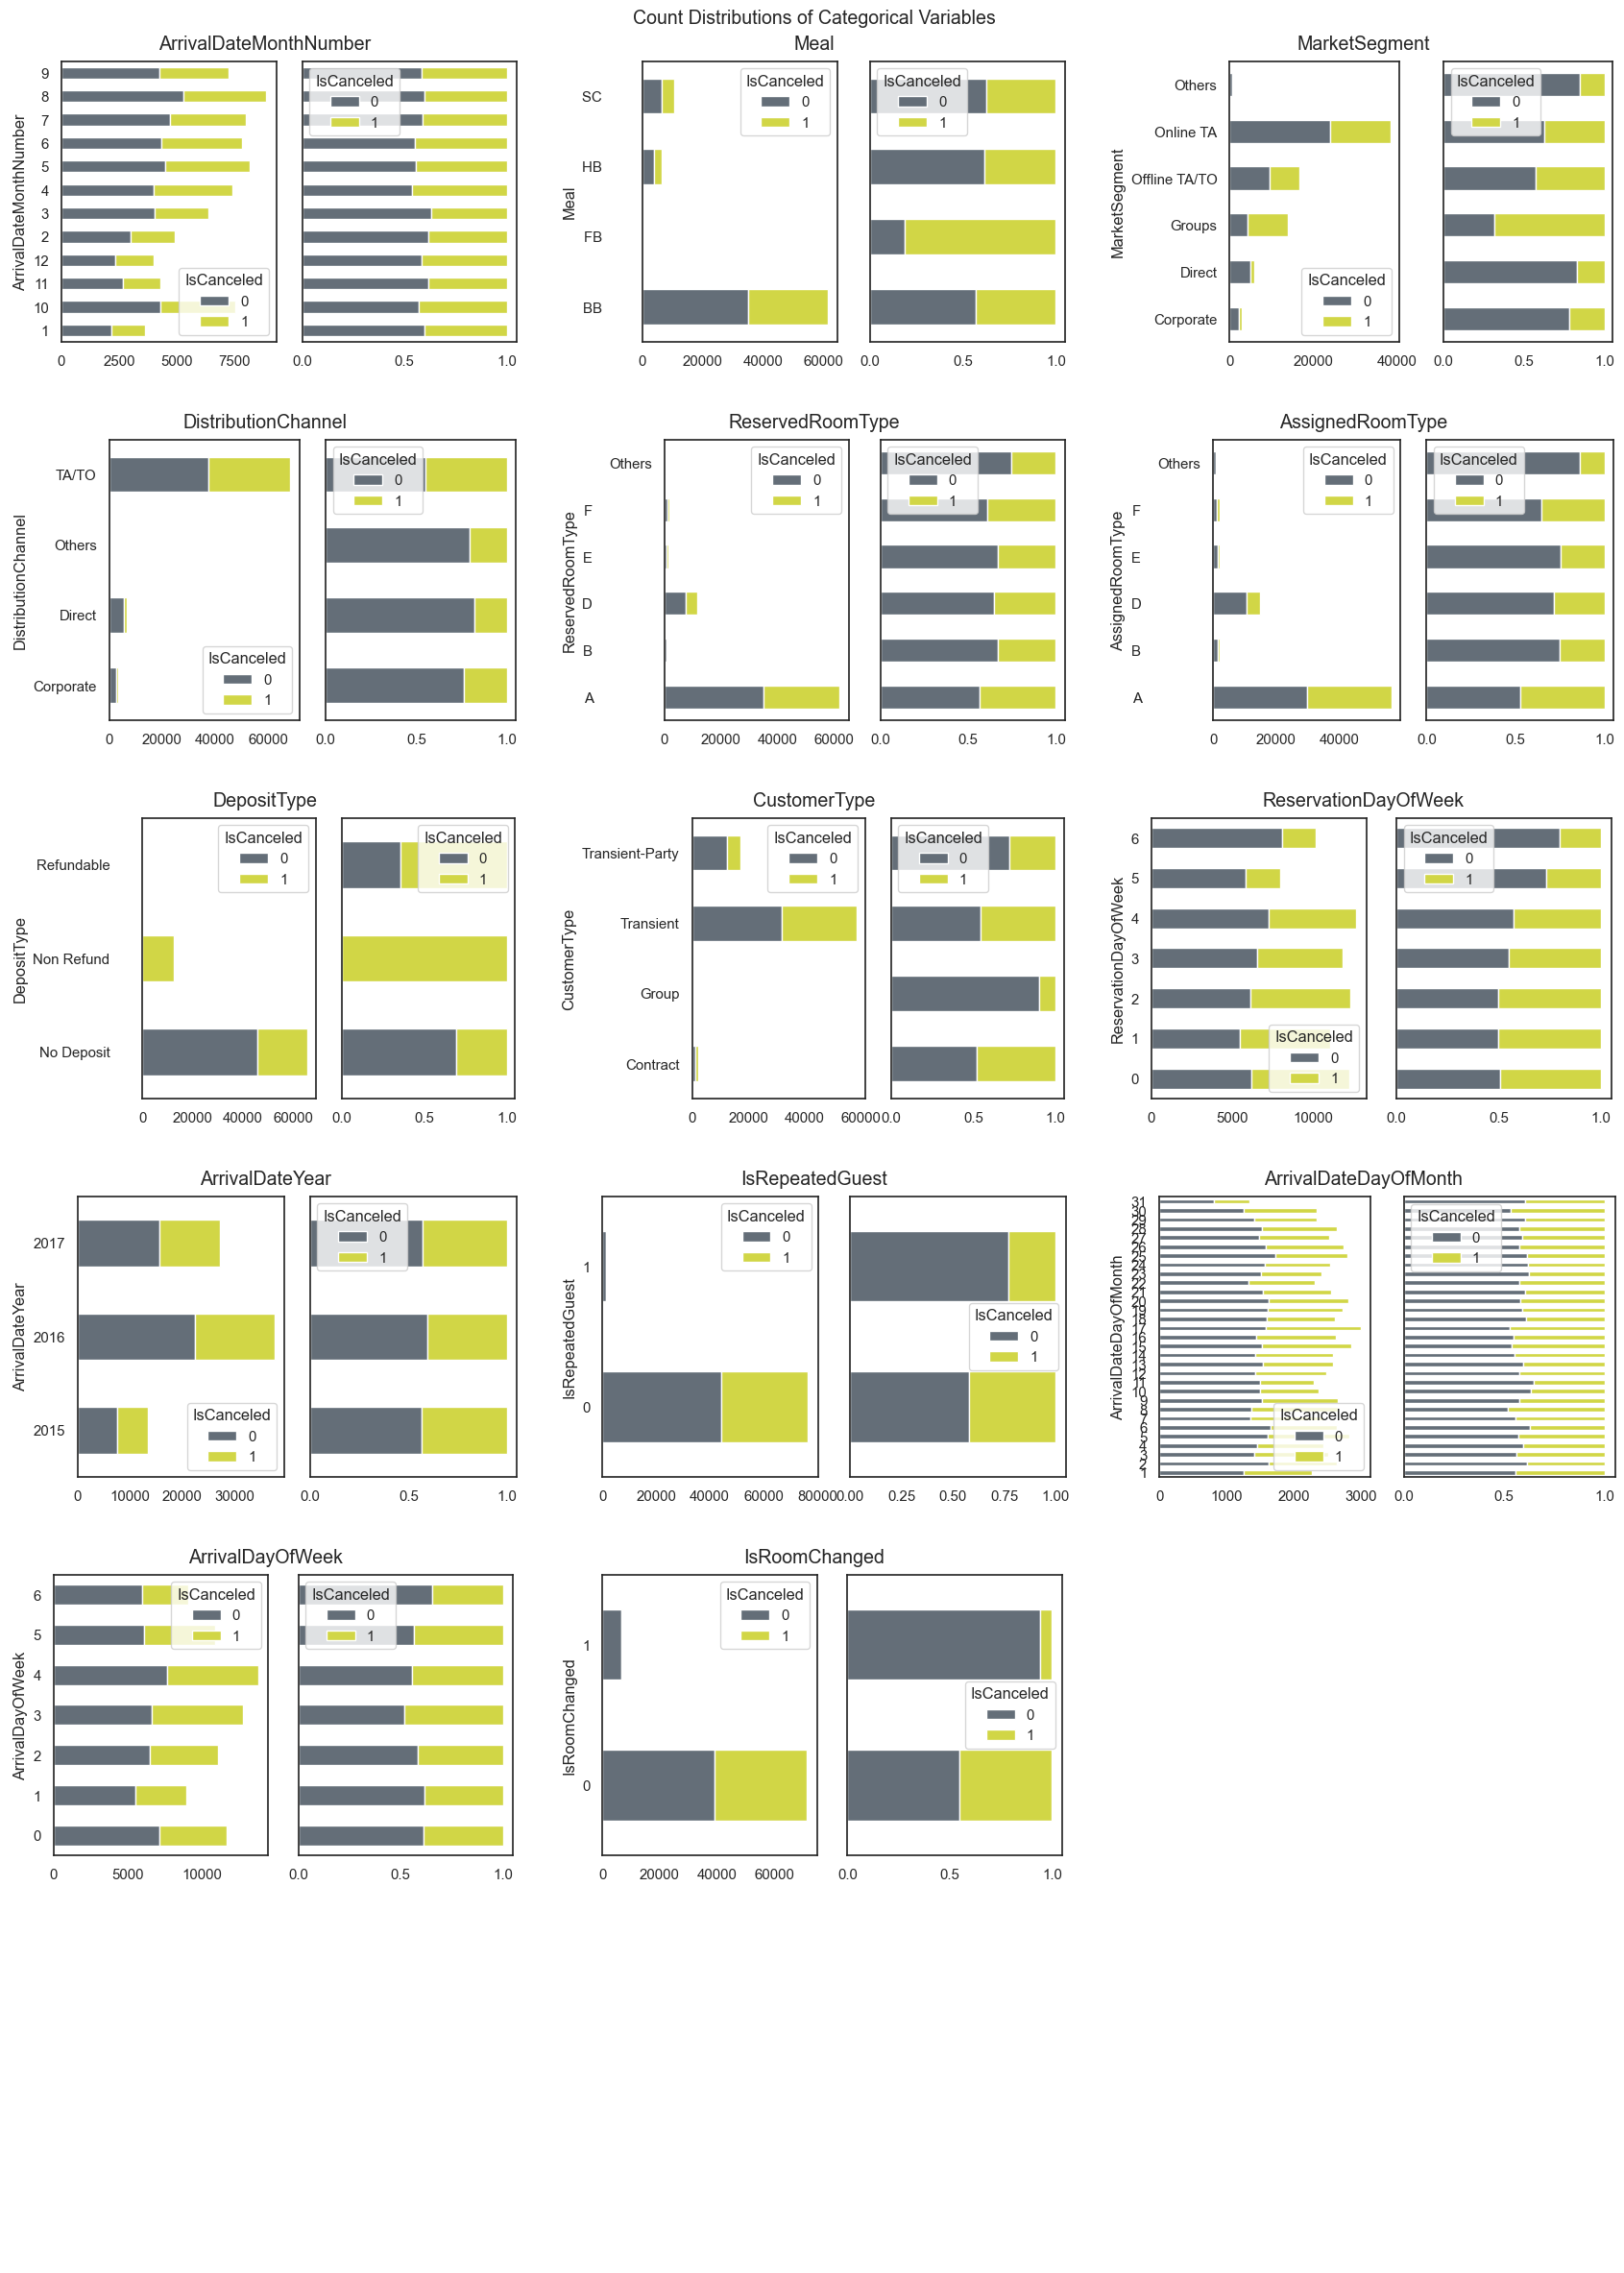

In [206]:
plot_cat_counts(data_out_rem, to_plot)


In [207]:
print("Percentage of data kept after outlier removal:", np.round((len(data_out_rem) / len(data)*100), 6), "%")

Percentage of data kept after outlier removal: 98.783562 %


In [208]:
data_out_rem.drop("Outliers", axis = 1, inplace = True)
df = data_out_rem.copy()

## ENCODING

In [209]:
data_ohc = df.copy()

In [210]:
categorical_features

['Meal',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'ReservedRoomType',
 'AssignedRoomType',
 'DepositType',
 'Agent',
 'Company',
 'CustomerType',
 'ReservationStatus',
 'ReservationStatusDate',
 'ArrivalDateMonthNumber',
 'ArrivalDate',
 'ArrivalDayOfWeek',
 'ReservationDayOfMonth',
 'ReservationWeekOfYear',
 'ReservationMonth',
 'ReservationDayOfWeek',
 'ArrivalDateYear',
 'ArrivalDateDayOfMonth',
 'IsRepeatedGuest',
 'IsCanceled',
 'IsRoomChanged']

In [211]:
#TODO discuss it --> is it worthy ? some models do not need it (ex DT)
#List of features to be encoded using one hot encoder
#IsRoomChanged, DepositType, IsRepeatedGuest, CustomerType, DistributionChannel, MarketSegment
to_encode = ['Meal', 'MarketSegment', 'DistributionChannel', 'DepositType', 'CustomerType']

In [212]:
ohc = OneHotEncoder(sparse=False)
ohc_feat = ohc.fit_transform(df[to_encode])
ohc_feat_names = ohc.get_feature_names(input_features=to_encode)
ohc_df = pd.DataFrame(ohc_feat, index=df.index, columns=ohc_feat_names)

ohc_df

,Meal_BB,Meal_FB,Meal_HB,Meal_SC,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Offline TA/TO,MarketSegment_Online TA,MarketSegment_Others,DistributionChannel_Corporate,DistributionChannel_Direct,DistributionChannel_Others,DistributionChannel_TA/TO,DepositType_No Deposit,DepositType_Non Refund,DepositType_Refundable,CustomerType_Contract,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
79326,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
79327,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
79328,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [213]:
df_ohc = pd.concat([data_ohc.drop(columns=categorical_features), ohc_df, data_ohc["IsCanceled"]], axis=1)
df_ohc

,LeadTime,ArrivalDateWeekNumber,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,DurationOfStay,TotalValue,Meal_BB,Meal_FB,Meal_HB,Meal_SC,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Offline TA/TO,MarketSegment_Online TA,MarketSegment_Others,DistributionChannel_Corporate,DistributionChannel_Direct,DistributionChannel_Others,DistributionChannel_TA/TO,DepositType_No Deposit,DepositType_Non Refund,DepositType_Refundable,CustomerType_Contract,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party,IsCanceled
0,-0.934996,-0.013244,-0.898493,-0.125622,-1.670911,-0.245496,-0.058601,-0.191934,-0.078169,-0.307861,-0.154607,-2.415092,-0.157286,-0.700484,-0.525057,-1.303034,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,-0.195909,-0.013244,-0.898493,1.247620,0.292610,-0.245496,-0.058601,-0.191934,-0.078169,-0.307861,-0.154607,-0.660612,-0.157286,0.580301,0.548523,-0.051777,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,-0.403214,-0.013244,-0.898493,1.247620,-1.670911,-0.245496,-0.058601,-0.191934,-0.078169,-0.307861,-0.154607,-0.855554,-0.157286,0.580301,0.548523,-0.190805,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,-0.159856,-0.013244,1.361341,1.247620,0.292610,-0.245496,-0.058601,-0.191934,-0.078169,-0.307861,-0.154607,-0.660612,-0.157286,1.861085,1.622104,0.573852,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4,-0.087750,-0.013244,-0.898493,-0.125622,0.292610,-0.245496,-0.058601,-0.191934,-0.078169,-0.307861,-0.154607,-0.660612,-0.157286,0.580301,-0.525057,-0.677406,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,-0.781770,0.583841,1.361341,1.934241,0.292610,-0.245496,-0.058601,-0.191934,-0.078169,-0.307861,-0.154607,-0.210181,-0.157286,-0.700484,2.158894,1.448833,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
79326,-0.069724,0.583841,1.361341,1.934241,2.256131,-0.245496,-0.058601,-0.191934,-0.078169,-0.307861,-0.154607,2.755004,-0.157286,1.861085,2.158894,5.149572,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
79327,-0.682625,0.583841,1.361341,1.934241,0.292610,-0.245496,-0.058601,-0.191934,-0.078169,-0.307861,-0.154607,1.201888,-0.157286,4.422655,2.158894,3.211185,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
79328,-0.006631,0.583841,1.361341,1.934241,0.292610,-0.245496,-0.058601,-0.191934,-0.078169,-0.307861,-0.154607,-0.020743,-0.157286,-0.700484,2.158894,1.685264,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [214]:
#TO AVOID ENCODING COMMENT THIS WHOLE CELL

#Adding encoded features to metric and removing from categorical
for feat in to_encode:
    categorical_features.remove(feat)

encoded_feat = []

#Taking out empty spaces for columns names
for feat in ohc_df.columns:
    feat2 = feat.replace(" ", "")
    encoded_feat.append(feat2)
    df_ohc.rename(columns = {feat:feat2}, inplace = True)

metric_features.extend(encoded_feat)

df = df_ohc.copy()

In [215]:
df

,LeadTime,ArrivalDateWeekNumber,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,DurationOfStay,TotalValue,Meal_BB,Meal_FB,Meal_HB,Meal_SC,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_OfflineTA/TO,MarketSegment_OnlineTA,MarketSegment_Others,DistributionChannel_Corporate,DistributionChannel_Direct,DistributionChannel_Others,DistributionChannel_TA/TO,DepositType_NoDeposit,DepositType_NonRefund,DepositType_Refundable,CustomerType_Contract,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party,IsCanceled
0,-0.934996,-0.013244,-0.898493,-0.125622,-1.670911,-0.245496,-0.058601,-0.191934,-0.078169,-0.307861,-0.154607,-2.415092,-0.157286,-0.700484,-0.525057,-1.303034,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,-0.195909,-0.013244,-0.898493,1.247620,0.292610,-0.245496,-0.058601,-0.191934,-0.078169,-0.307861,-0.154607,-0.660612,-0.157286,0.580301,0.548523,-0.051777,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,-0.403214,-0.013244,-0.898493,1.247620,-1.670911,-0.245496,-0.058601,-0.191934,-0.078169,-0.307861,-0.154607,-0.855554,-0.157286,0.580301,0.548523,-0.190805,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,-0.159856,-0.013244,1.361341,1.247620,0.292610,-0.245496,-0.058601,-0.191934,-0.078169,-0.307861,-0.154607,-0.660612,-0.157286,1.861085,1.622104,0.573852,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4,-0.087750,-0.013244,-0.898493,-0.125622,0.292610,-0.245496,-0.058601,-0.191934,-0.078169,-0.307861,-0.154607,-0.660612,-0.157286,0.580301,-0.525057,-0.677406,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,-0.781770,0.583841,1.361341,1.934241,0.292610,-0.245496,-0.058601,-0.191934,-0.078169,-0.307861,-0.154607,-0.210181,-0.157286,-0.700484,2.158894,1.448833,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
79326,-0.069724,0.583841,1.361341,1.934241,2.256131,-0.245496,-0.058601,-0.191934,-0.078169,-0.307861,-0.154607,2.755004,-0.157286,1.861085,2.158894,5.149572,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
79327,-0.682625,0.583841,1.361341,1.934241,0.292610,-0.245496,-0.058601,-0.191934,-0.078169,-0.307861,-0.154607,1.201888,-0.157286,4.422655,2.158894,3.211185,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
79328,-0.006631,0.583841,1.361341,1.934241,0.292610,-0.245496,-0.058601,-0.191934,-0.078169,-0.307861,-0.154607,-0.020743,-0.157286,-0.700484,2.158894,1.685264,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0


# Feature Selection

In [216]:
df_train = df.copy()
df_train.drop("IsCanceled", axis = 1, inplace = True)
target = df["IsCanceled"]

In [103]:
from scipy.stats import fisher_exact
from statsmodels.graphics.mosaicplot import mosaic

### RFE Regression

In [217]:
# ## This is running forever. Code needs to be modified.

# nof_list=np.arange(1,15)            
# high_score=0
# #Variable to store the optimum features
# nof=0           
# score_list =[]
# for n in range(len(nof_list)):
#     model = RandomForestRegressor()
#     rfe = RFE(estimator = model, n_features_to_select = nof_list[n])
#     x_train_rfe = rfe.fit_transform(df_train, target)
#     x_train_rfe = rfe.transform(df_train)
#     model.fit(x_train_rfe, df['IsCanceled'])
    
#     score = model.score(x_train_rfe, df['IsCanceled'])
#     score_list.append(score)
    
#     if(score>high_score):
#         high_score = score
#         nof = nof_list[n]
# print("Optimum number of features: %d" %nof)
# print("Score with %d features: %f" % (nof, high_score))
# nof_list

In [218]:
# from sklearn.ensemble import RandomForestRegressor
# model = RandomForestRegressor()
# rfe = RFE(estimator = model, n_features_to_select = nof)
# x_rfe = rfe.fit_transform(X = df_train, y = target)
# print(rfe.support_)
# print(rfe.ranking_)
# selected_features = pd.Series(rfe.support_, index = df.columns)
# selected_features

### Lasso

In [219]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    fig,ax=plt.subplots(figsize=(7,4))
    imp_coef.plot(kind = "barh", ax=ax)
    title = "Feature importance using " + name + " Model"
    plt.title(title)
    if save_plots:
            save_fig(title, fig)        
    plt.show()

Lasso picked 30 variables and eliminated the other 7 variables


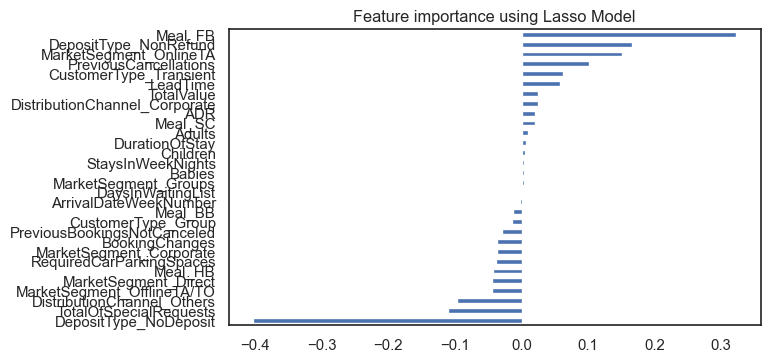

LeadTime                         0.058431
ArrivalDateWeekNumber           -0.003030
StaysInWeekNights                0.004307
Adults                           0.009787
Children                         0.005561
Babies                           0.003805
PreviousCancellations            0.100909
PreviousBookingsNotCanceled     -0.029078
BookingChanges                  -0.036550
DaysInWaitingList                0.002769
ADR                              0.019931
RequiredCarParkingSpaces        -0.038575
TotalOfSpecialRequests          -0.109947
DurationOfStay                   0.006482
TotalValue                       0.025062
Meal_BB                         -0.012084
Meal_FB                          0.322977
Meal_HB                         -0.043233
Meal_SC                          0.019915
MarketSegment_Corporate         -0.036570
MarketSegment_Direct            -0.043776
MarketSegment_Groups             0.003608
MarketSegment_OfflineTA/TO      -0.044169
MarketSegment_OnlineTA           0

In [220]:
reg = LassoCV()
reg.fit(df_train, target)
coef = pd.Series(reg.coef_, index = df_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
coef.sort_values()
plot_importance(coef[coef!=0],'Lasso')
bf_lasso = coef[coef!=0].index
coef[coef!=0]

In [221]:
bf_lasso

Index(['LeadTime', 'ArrivalDateWeekNumber', 'StaysInWeekNights', 'Adults',
       'Children', 'Babies', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList',
       'ADR', 'RequiredCarParkingSpaces', 'TotalOfSpecialRequests',
       'DurationOfStay', 'TotalValue', 'Meal_BB', 'Meal_FB', 'Meal_HB',
       'Meal_SC', 'MarketSegment_Corporate', 'MarketSegment_Direct',
       'MarketSegment_Groups', 'MarketSegment_OfflineTA/TO',
       'MarketSegment_OnlineTA', 'DistributionChannel_Corporate',
       'DistributionChannel_Others', 'DepositType_NoDeposit',
       'DepositType_NonRefund', 'CustomerType_Group',
       'CustomerType_Transient'],
      dtype='object')

### Mutual info

In [222]:
class UnivariateFeatureSelction:
    def __init__(self, n_features, problem_type, scoring, return_cols=True):
        """
        Custom univariate feature selection wrapper on
        different univariate feature selection models from
        scikit-learn.
        :param n_features: SelectPercentile if float else SelectKBest
        :param problem_type: classification or regression
        :param scoring: scoring function, string
        """

        self.n_features = n_features
        
        if problem_type == "classification":
            valid_scoring = {
                "f_classif": f_classif,
                "chi2": chi2,
                "mutual_info_classif": mutual_info_classif
            }
        else:
            valid_scoring = {
                "f_regression": f_regression,
                "mutual_info_regression": mutual_info_regression
            }
        if scoring not in valid_scoring:
            raise Exception("Invalid scoring function")
            
        if isinstance(n_features, int):
            self.selection = SelectKBest(
                valid_scoring[scoring],
                k=n_features
            )
        elif isinstance(n_features, float):
            self.selection = SelectPercentile(valid_scoring[scoring], percentile=int(n_features * 100))
        else:
            raise Exception("Invalid type of feature")
    
    def fit(self, X, y):
        return self.selection.fit(X, y)
    
    def transform(self, X):
        return self.selection.transform(X)
    
    def fit_transform(self, X, y):
        return self.selection.fit_transform(X, y)
    
    def return_cols(self, X):
        if isinstance(self.n_features, int):
            mask = SelectKBest.get_support(self.selection)
            selected_features = []
            features = list(X.columns)
            for bool, feature in zip(mask, features):
                if bool:
                    selected_features.append(feature)
                    
        elif isinstance(self.n_features, float):
            mask = SelectPercentile.get_support(self.selection)
            selected_features = []
            features = list(X.columns)
            for bool, feature in zip(mask, features):
                if bool:
                    selected_features.append(feature)
        else:
            raise Exception("Invalid type of feature")
        
        return selected_features

In [223]:
ufs = UnivariateFeatureSelction(
    n_features=0.25,
    problem_type="classification",
    scoring="mutual_info_classif"
)

ufs.fit(df_train, target.values.ravel())
bf_mic = ufs.return_cols(df_train)

In [224]:
print(len(bf_mic))
bf_mic

9


['LeadTime',
 'PreviousCancellations',
 'BookingChanges',
 'ADR',
 'TotalOfSpecialRequests',
 'TotalValue',
 'MarketSegment_Groups',
 'DepositType_NoDeposit',
 'DepositType_NonRefund']